In [55]:
pip install wordcloud

In [1]:
import pandas as pd

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk

In [3]:
from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [56]:
from wordcloud import WordCloud

In [4]:
splits = {'train': 'train.json', 'test': 'test.json'}

In [5]:
train = pd.read_json("hf://datasets/jason23322/high-accuracy-email-classifier/" + splits["train"])

In [6]:
test = pd.read_json("hf://datasets/jason23322/high-accuracy-email-classifier/"+splits["test"])

In [7]:
train_df = train.copy()

In [8]:
test_df = test.copy()

In [9]:
train_df.shape

(10780, 6)

In [10]:
test_df.shape

(2697, 6)

In [11]:
train_df.head(10)

id                                         subject  \
0    promotions_582       Anniversary Special: Buy one get one free   
1         spam_1629              Your Amazon was used on new device   
2          spam_322                         Re: Your Google inquiry   
3   social_media_80              Digital Ritual Experience Creation   
4        forum_1351       Your post was moved to "Programming Help"   
5  social_media_872                 Memories from this week in 2021   
6          spam_220                            PayPal Funds Release   
7   verify_code_483              Two-step verification code: 426706   
8  verify_code_1970                    Secure access number: 892974   
9        forum_1657  Moderation notice: Community Guidelines update   

                                                body  \
0  As our loyal customer, get exclusive $60 off $...   
1  Your $5000 refund is processed. Claim: bit.ly/...   
2  Hi, following up about your Google application...   
3  Cross-cultural ceremony design. Join: virtualr...   
4  Trending: "cooking" (258 comments). View: supp...   
5  45 friends checked in at "Downtown Cafe". See ...   
6  $750 held for verification. Confirm: paypal-fu...   
7  For account verification, enter: 924578. Do no...   
8  Enter 426706 to verify password reset. Session...   
9  Thread "Discussion 719" moved from General to ...   

                                                text      category  \
0  Anniversary Special: Buy one get one free As o...    promotions   
1  Your Amazon was used on new device Your $5000 ...          spam   
2  Re: Your Google inquiry Hi, following up about...          spam   
3  Digital Ritual Experience Creation Cross-cultu...  social_media   
4  Your post was moved to "Programming Help" Tren...         forum   
5  Memories from this week in 2021 45 friends che...  social_media   
6  PayPal Funds Release $750 held for verificatio...          spam   
7  Two-step verification code: 426706 For account...   verify_code   
8  Secure access number: 892974 Enter 426706 to v...   verify_code   
9  Moderation notice: Community Guidelines update...         forum   

   category_id  
0            1  
1            3  
2            3  
3            2  
4            0  
5            2  
6            3  
7            5  
8            5  
9            0

In [12]:
train_df['category'].unique()

array(['promotions', 'spam', 'social_media', 'forum', 'verify_code',
       'updates'], dtype=object)

In [13]:
train_df['category_id'].unique()

array([1, 3, 2, 0, 5, 4], dtype=int64)

In [14]:
length = len(train_df['text'][0])

In [15]:
print(f'Length of a sample review: {length}')

Length of a sample review: 132


In [16]:
train_df['text'][0]

'Anniversary Special: Buy one get one free As our loyal customer, get exclusive $60 off $75+: example.com/6058 Offer code: WELCOME20.'

In [17]:
train_df['body'][0]

'As our loyal customer, get exclusive $60 off $75+: example.com/6058 Offer code: WELCOME20.'

In [18]:
train_df['subject'][0]

'Anniversary Special: Buy one get one free'

In [18]:
train_df.columns

Index(['id', 'subject', 'body', 'text', 'category', 'category_id'], dtype='object')

In [19]:
def add_text_lengths(df, col_names):
    for col in col_names:
        df[f"{col}_word_count"] = df[col].astype(str).apply(lambda x: len(x.split()))
        df[f"{col}_length"] = df[col].astype(str).apply(len)
    return df

In [20]:
train_df = add_text_lengths(train_df,['subject','body','text'])

In [21]:
train_df.head(10)

id                                         subject  \
0    promotions_582       Anniversary Special: Buy one get one free   
1         spam_1629              Your Amazon was used on new device   
2          spam_322                         Re: Your Google inquiry   
3   social_media_80              Digital Ritual Experience Creation   
4        forum_1351       Your post was moved to "Programming Help"   
5  social_media_872                 Memories from this week in 2021   
6          spam_220                            PayPal Funds Release   
7   verify_code_483              Two-step verification code: 426706   
8  verify_code_1970                    Secure access number: 892974   
9        forum_1657  Moderation notice: Community Guidelines update   

                                                body  \
0  As our loyal customer, get exclusive $60 off $...   
1  Your $5000 refund is processed. Claim: bit.ly/...   
2  Hi, following up about your Google application...   
3  Cross-cultural ceremony design. Join: virtualr...   
4  Trending: "cooking" (258 comments). View: supp...   
5  45 friends checked in at "Downtown Cafe". See ...   
6  $750 held for verification. Confirm: paypal-fu...   
7  For account verification, enter: 924578. Do no...   
8  Enter 426706 to verify password reset. Session...   
9  Thread "Discussion 719" moved from General to ...   

                                                text      category  \
0  Anniversary Special: Buy one get one free As o...    promotions   
1  Your Amazon was used on new device Your $5000 ...          spam   
2  Re: Your Google inquiry Hi, following up about...          spam   
3  Digital Ritual Experience Creation Cross-cultu...  social_media   
4  Your post was moved to "Programming Help" Tren...         forum   
5  Memories from this week in 2021 45 friends che...  social_media   
6  PayPal Funds Release $750 held for verificatio...          spam   
7  Two-step verification code: 426706 For account...   verify_code   
8  Secure access number: 892974 Enter 426706 to v...   verify_code   
9  Moderation notice: Community Guidelines update...         forum   

   category_id  subject_word_count  subject_length  body_word_count  \
0            1                   7              41               13   
1            3                   7              34               10   
2            3                   4              23               18   
3            2                   4              34                7   
4            0                   7              41                6   
5            2                   6              31               12   
6            3                   3              20                8   
7            5                   4              34               10   
8            5                   4              28               13   
9            0                   5              46               10   

   body_length  text_word_count  text_length  
0           90               20          132  
1           81               17          116  
2          117               22          141  
3           85               11          120  
4           66               13          108  
5           86               18          118  
6           73               11           94  
7           66               14          101  
8           89               17          118  
9           89               15          136

<Axes: xlabel='category', ylabel='count'>

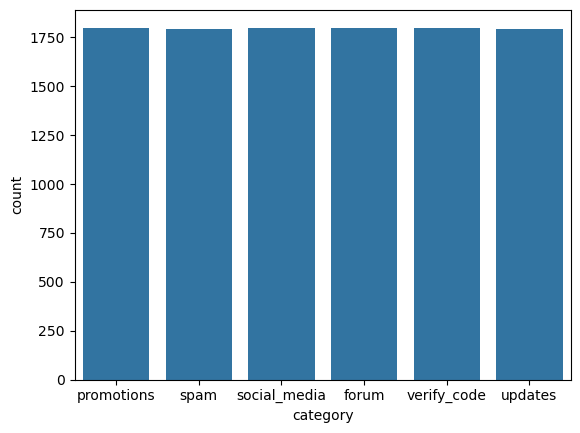

In [22]:
sns.countplot(data=train_df,x='category')

In [23]:
def avg_word_and_sentence_length(df, col_names):
    for col in col_names:
        df[f"{col}_avg_word_length"] = df[col].astype(str).map(
            lambda x: np.mean([len(word) for word in x.split()]) if len(x.split()) > 0 else 0
        )
        df[f"{col}_avg_sentence_length"] = df[col].astype(str).map(
            lambda x: np.mean([len(sent) for sent in tokenize.sent_tokenize(x)]) if len(x) > 0 else 0
        )
    return df 

In [24]:
train_df = avg_word_and_sentence_length(train_df,['body','text'])

In [26]:
train_df = avg_word_and_sentence_length(train_df,['subject'])

In [27]:
train_df.head()

id                                    subject  \
0   promotions_582  Anniversary Special: Buy one get one free   
1        spam_1629         Your Amazon was used on new device   
2         spam_322                    Re: Your Google inquiry   
3  social_media_80         Digital Ritual Experience Creation   
4       forum_1351  Your post was moved to "Programming Help"   

                                                body  \
0  As our loyal customer, get exclusive $60 off $...   
1  Your $5000 refund is processed. Claim: bit.ly/...   
2  Hi, following up about your Google application...   
3  Cross-cultural ceremony design. Join: virtualr...   
4  Trending: "cooking" (258 comments). View: supp...   

                                                text      category  \
0  Anniversary Special: Buy one get one free As o...    promotions   
1  Your Amazon was used on new device Your $5000 ...          spam   
2  Re: Your Google inquiry Hi, following up about...          spam   
3  Digital Ritual Experience Creation Cross-cultu...  social_media   
4  Your post was moved to "Programming Help" Tren...         forum   

   category_id  subject_word_count  subject_length  body_word_count  \
0            1                   7              41               13   
1            3                   7              34               10   
2            3                   4              23               18   
3            2                   4              34                7   
4            0                   7              41                6   

   body_length  text_word_count  text_length  body_avg_word_length  \
0           90               20          132              6.000000   
1           81               17          116              7.200000   
2          117               22          141              5.555556   
3           85               11          120             11.285714   
4           66               13          108             10.166667   

   body_avg_sentence_length  text_avg_word_length  text_avg_sentence_length  \
0                      90.0              5.650000                     132.0   
1                      40.0              5.882353                      57.5   
2                      28.5              5.454545                      34.5   
3                      42.0             10.000000                      59.5   
4                      32.5              7.384615                      53.5   

   subject_avg_word_length  subject_avg_sentence_length  
0                     5.00                         41.0  
1                     4.00                         34.0  
2                     5.00                         23.0  
3                     7.75                         34.0  
4                     5.00                         41.0

In [28]:
train_df.columns

Index(['id', 'subject', 'body', 'text', 'category', 'category_id',
       'subject_word_count', 'subject_length', 'body_word_count',
       'body_length', 'text_word_count', 'text_length', 'body_avg_word_length',
       'body_avg_sentence_length', 'text_avg_word_length',
       'text_avg_sentence_length', 'subject_avg_word_length',
       'subject_avg_sentence_length'],
      dtype='object')

In [32]:
def visualize(col):
    plt.figure(figsize=(12,10))
    plt.subplot(1,2,1)
    sns.boxplot(y=train_df[col], hue=train_df['category'])
    plt.ylabel(col, labelpad=12.5)
    
    plt.subplot(1,2,2)
    sns.kdeplot(train_df, x=col, hue="category", common_norm=False, fill=True)
    plt.legend(train_df['category'].unique(), bbox_to_anchor=(1.05, 1), loc='upper right')
    plt.xlabel('')
    plt.ylabel('')
    
    plt.show()

In [30]:
features = train_df.columns.to_list()[6:]

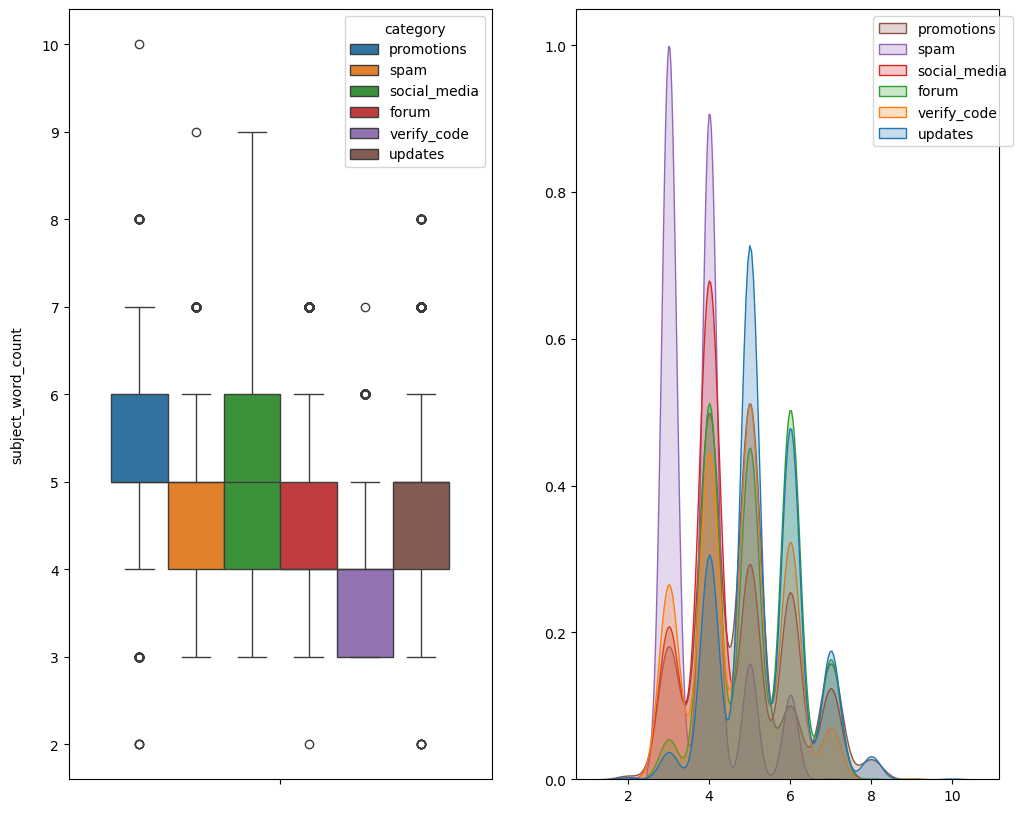

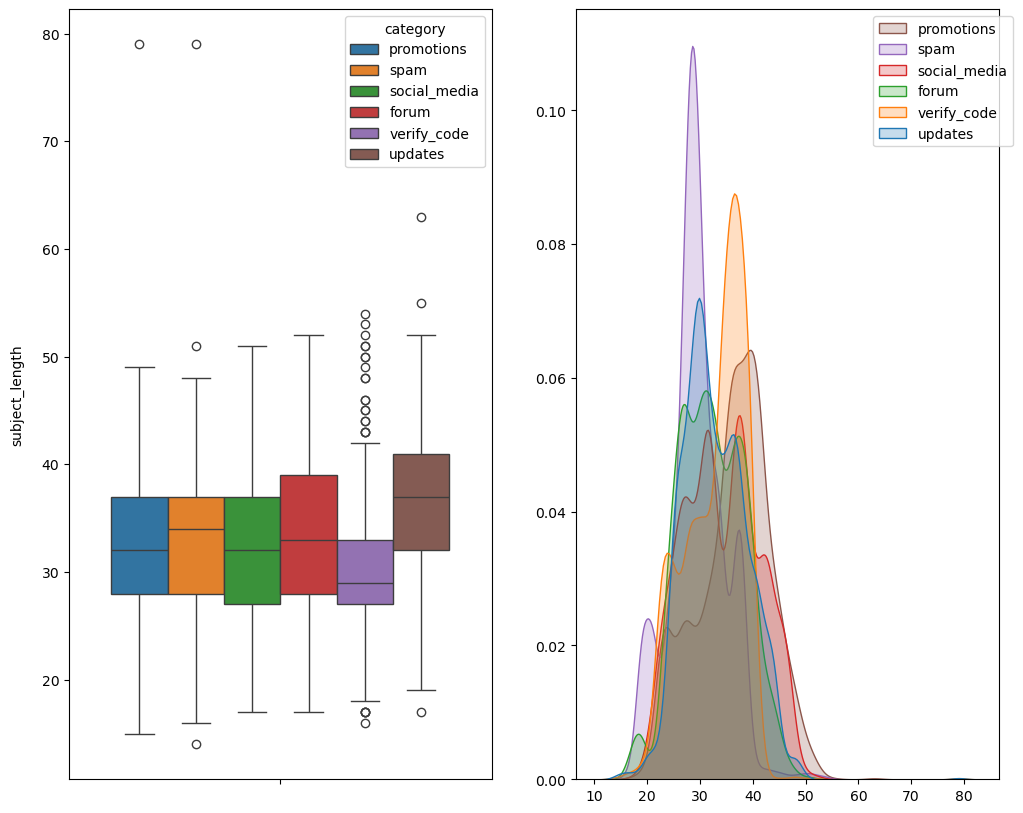

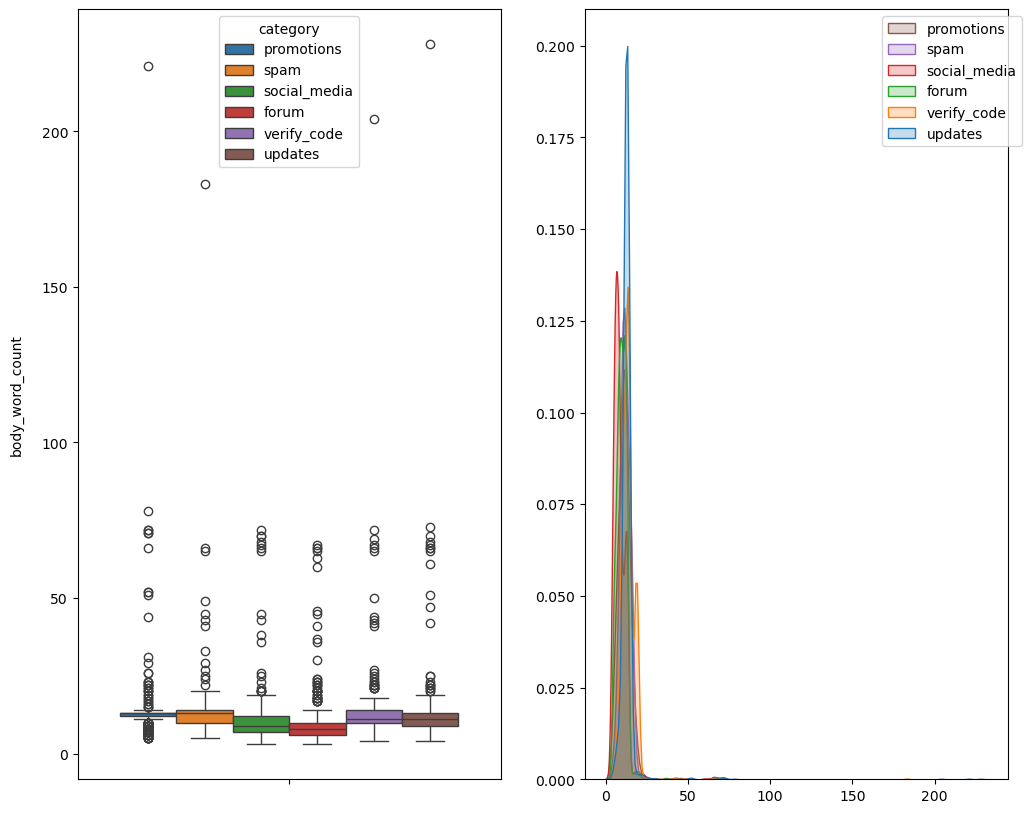

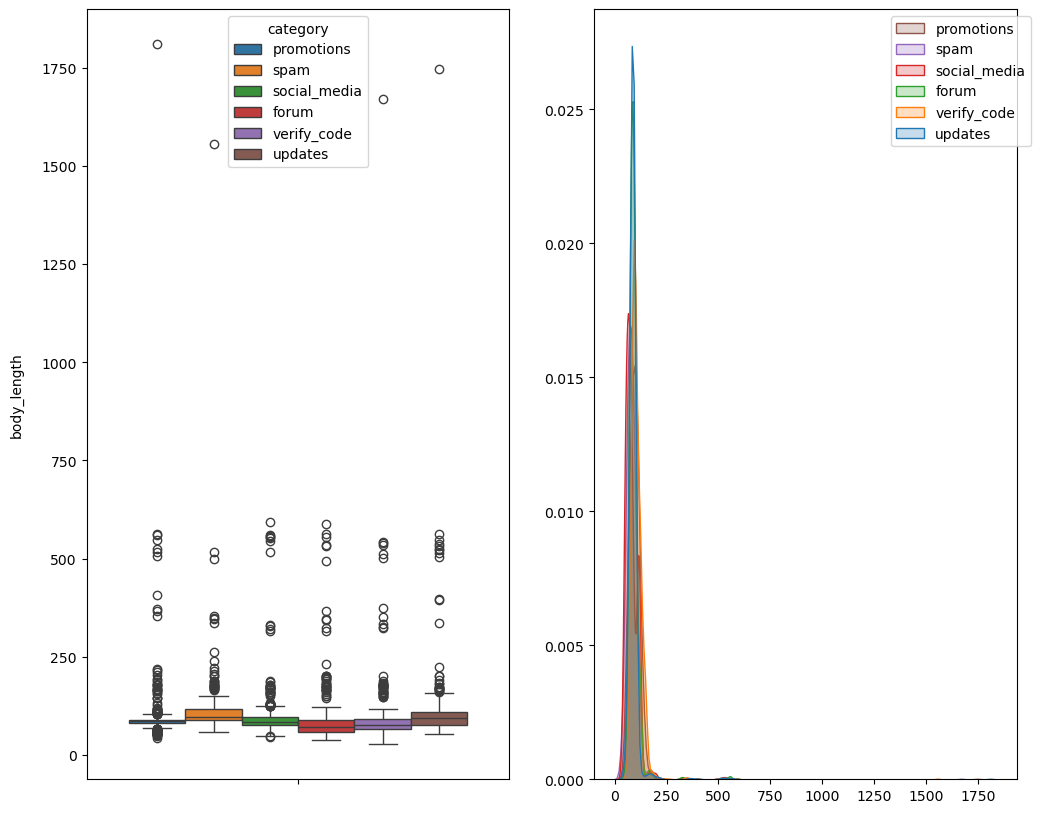

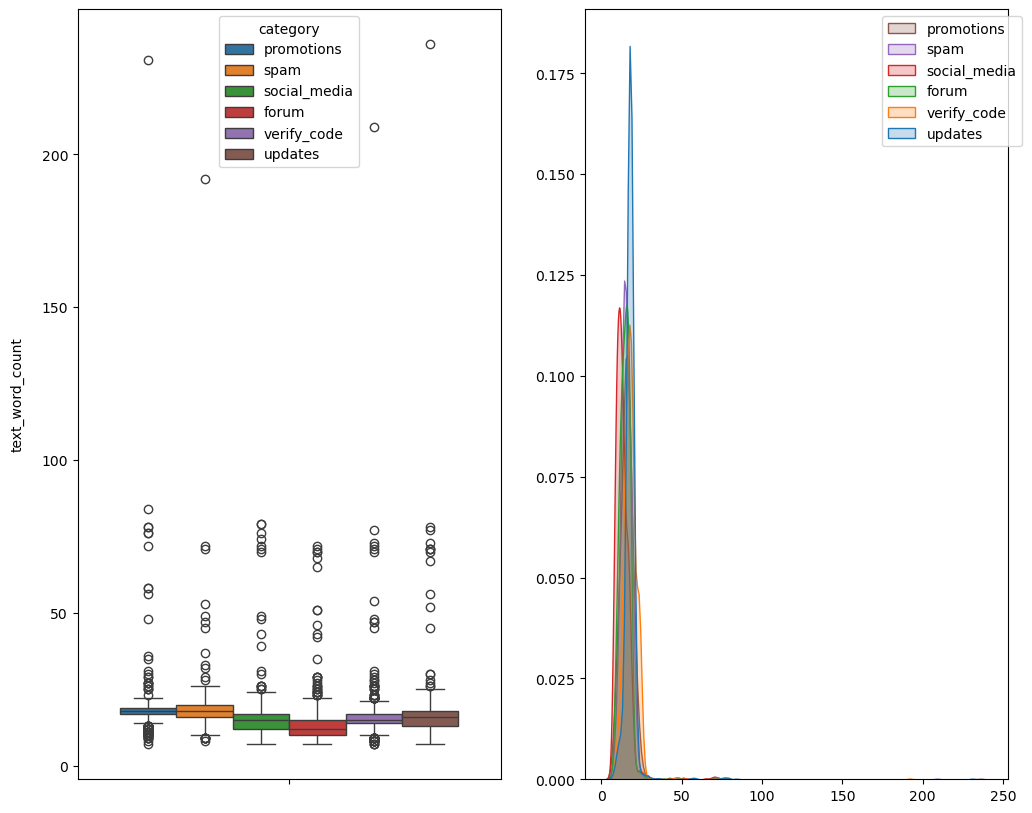

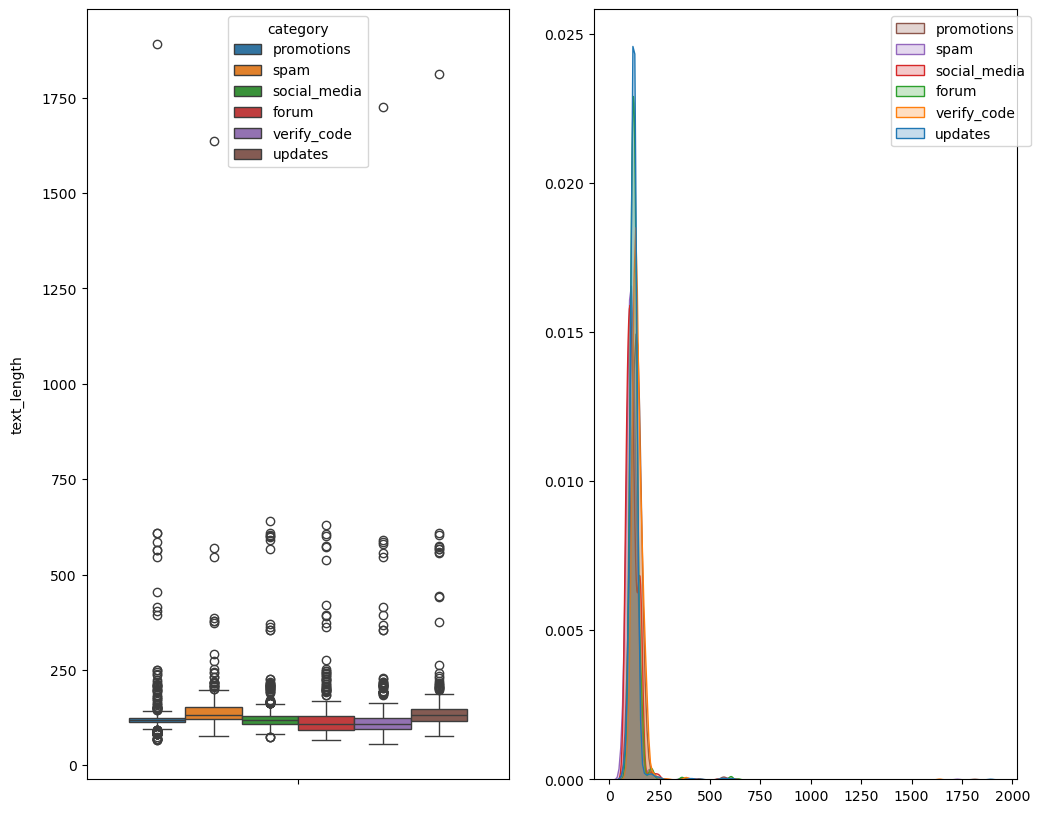

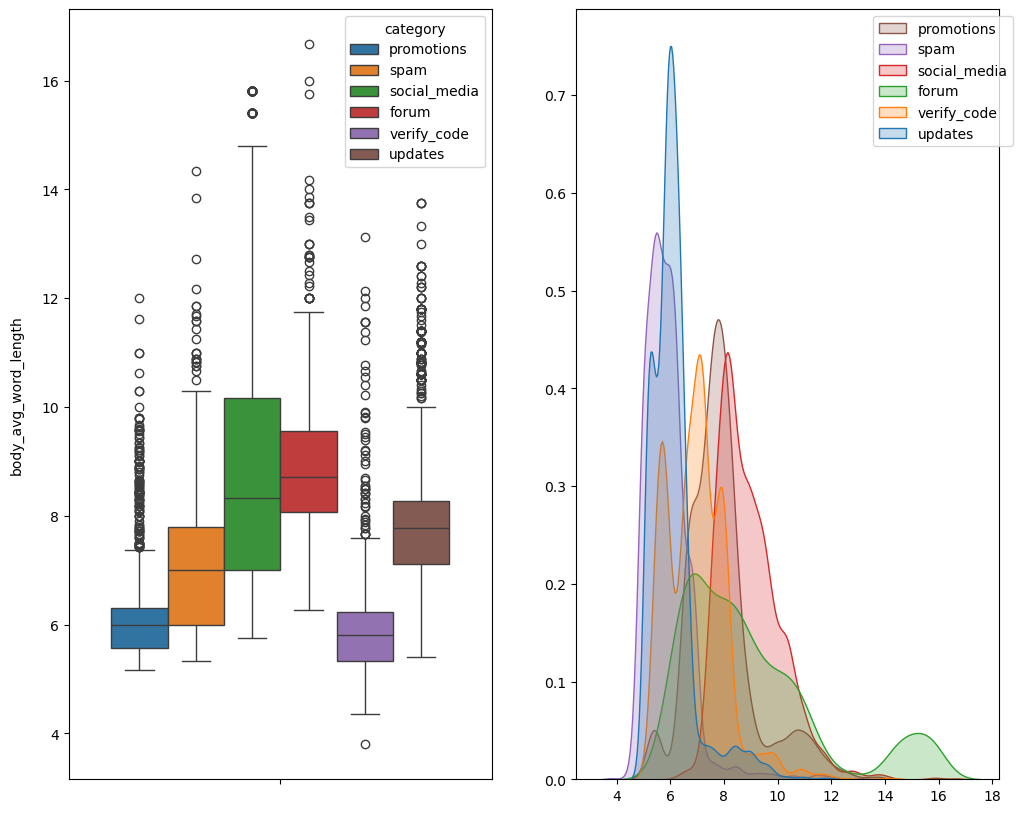

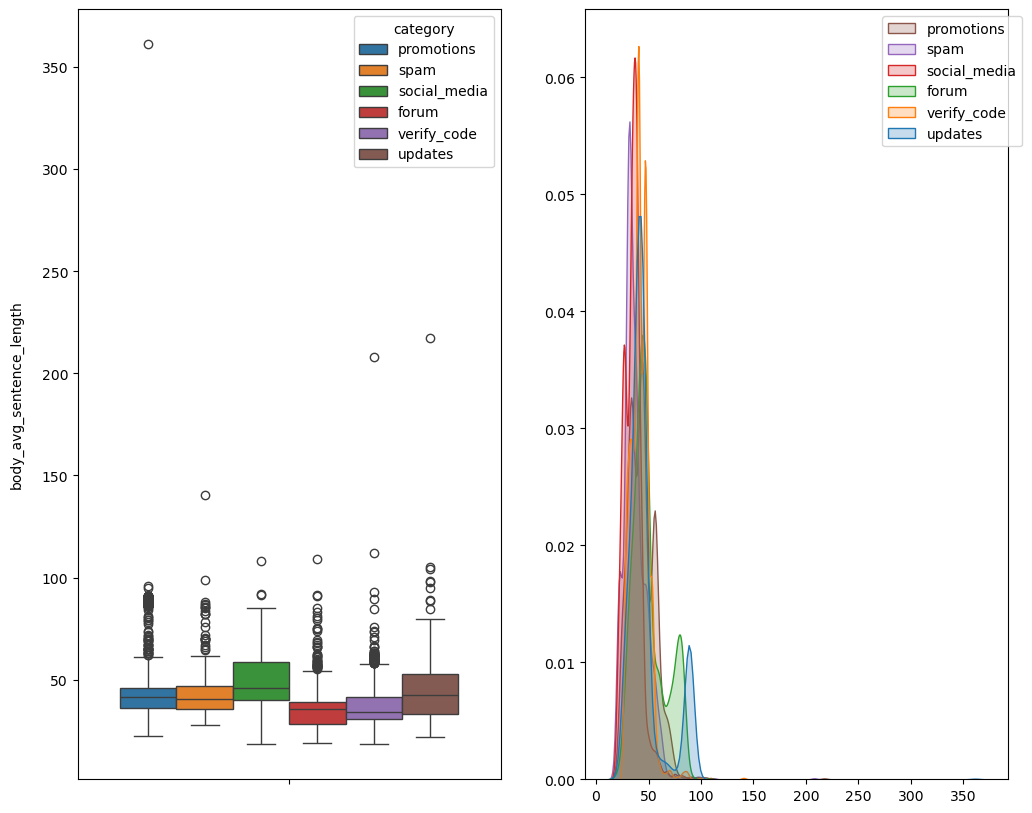

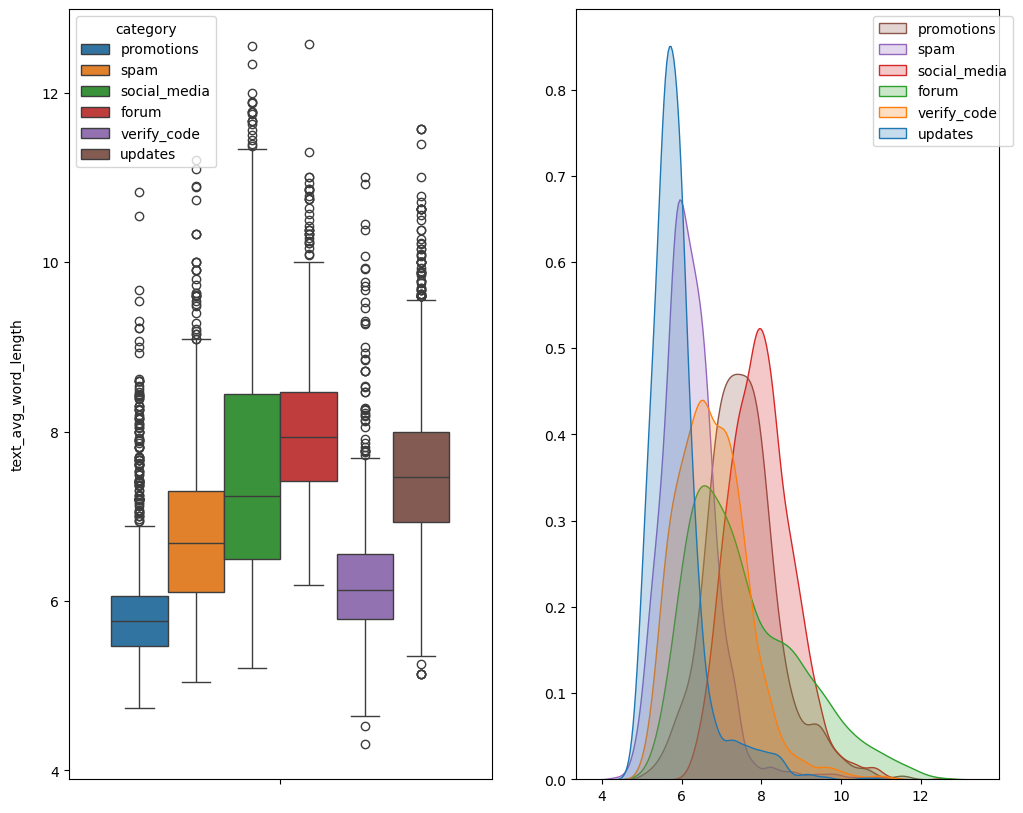

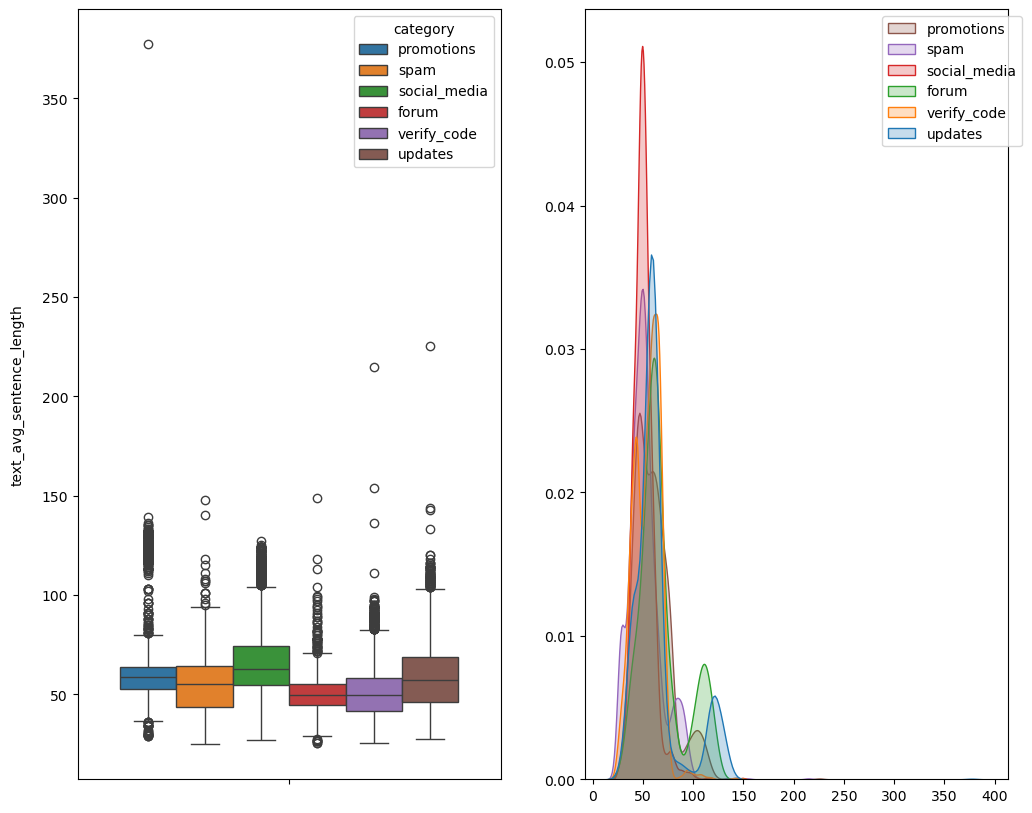

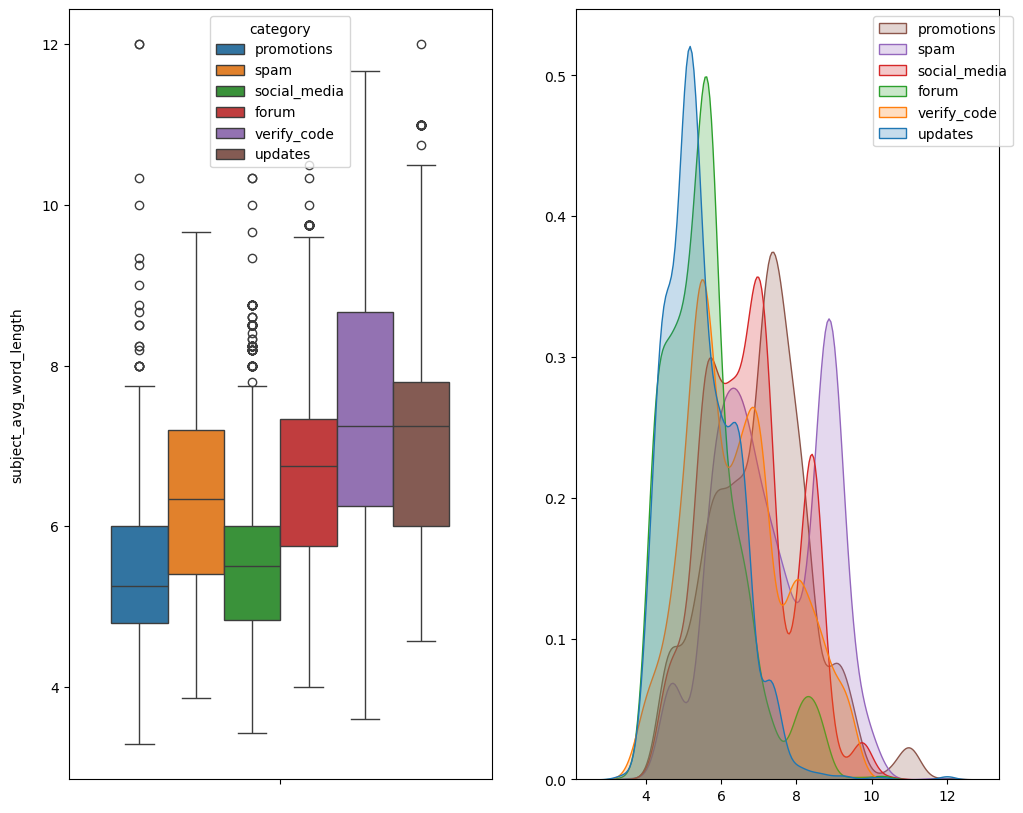

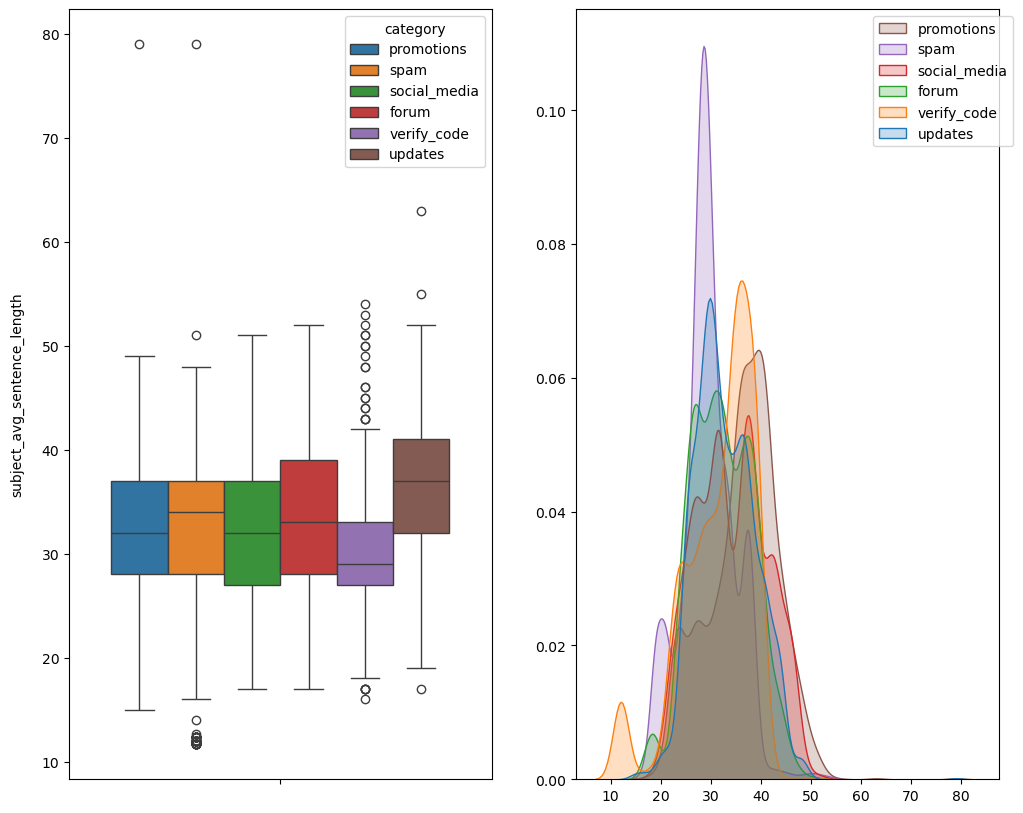

In [33]:
for feature in features:
    visualize(feature)

In [34]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nandita\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [35]:
def clean_texts(col): 
    col = col.lower() 
    col = re.sub(r"\d+", " num ", col)  
    col = re.sub(r"[^\w\s!?]", "", col)  
    col = " ".join([word for word in col.split() if word not in stopwords.words('english')])  
    return col

In [36]:
train_df['body_normalized'] = train_df['body'].astype(str).apply(clean_texts)

In [42]:
train_df['body_normalized'][100]

'see messaged paypal! view bitlyfakeprize special offer num membership'

In [43]:
train_df['text_normalized'] = train_df['text'].astype(str).apply(clean_texts)

In [44]:
train_df['text_normalized'][0]

'anniversary special buy one get one free loyal customer get exclusive num num examplecom num offer code welcome num'

In [63]:
train_df['subject_normalized'] = train_df['subject'].astype(str).apply(clean_texts)

In [64]:
train_df['subject_normalized'][0]

'anniversary special buy one get one free'

In [49]:
stop_words = set(stopwords.words("english"))

In [50]:
def get_tokens(text):
    return [word for word in nltk.word_tokenize(text.lower()) if word.isalpha() and word not in stop_words]

In [51]:
all_words = []
for doc in train_df['body_normalized']:
    all_words.extend(get_tokens(doc))

word_freq = Counter(all_words)

In [52]:
word_freq.most_common(50)

[('num', 17236),
 ('code', 2086),
 ('examplecom', 1594),
 ('view', 1298),
 ('new', 1155),
 ('account', 910),
 ('payment', 881),
 ('items', 802),
 ('use', 748),
 ('expires', 735),
 ('enter', 708),
 ('shop', 692),
 ('update', 689),
 ('support', 676),
 ('see', 636),
 ('group', 613),
 ('time', 589),
 ('forumcomthread', 571),
 ('phishingsitecom', 553),
 ('bitlyfakeprize', 542),
 ('wikisitepage', 518),
 ('supportsiteticket', 515),
 ('scamdeliverycom', 514),
 ('within', 508),
 ('minutes', 487),
 ('hrshrs', 474),
 ('password', 471),
 ('valid', 465),
 ('comments', 464),
 ('companycomupdates', 462),
 ('effective', 442),
 ('ends', 436),
 ('required', 435),
 ('thread', 422),
 ('features', 416),
 ('bankingcomstatements', 413),
 ('login', 408),
 ('offer', 407),
 ('review', 382),
 ('servicecomstatus', 382),
 ('user', 377),
 ('claim', 369),
 ('action', 364),
 ('complete', 362),
 ('changes', 361),
 ('share', 359),
 ('security', 352),
 ('verify', 350),
 ('posted', 349),
 ('verification', 339)]

In [53]:
def plot_top_words_per_category(df, text_col, label_col, top_n=15):
    category_word_freq = {}

    for label in df[label_col].unique():
        docs = df[df[label_col] == label][text_col]
        words = []
        for doc in docs:
            words.extend(get_tokens(doc))
        category_word_freq[label] = Counter(words).most_common(top_n)

    # Plot subplots
    n_cat = len(category_word_freq)
    fig, axes = plt.subplots(n_cat, 1, figsize=(10, 5*n_cat))

    if n_cat == 1:
        axes = [axes]  # ensure iterable

    for ax, (cat, words) in zip(axes, category_word_freq.items()):
        words_, counts_ = zip(*words)
        ax.bar(words_, counts_, color="skyblue")
        ax.set_title(f"Top {top_n} Words in Category: {cat}", fontsize=14)
        ax.set_xticklabels(words_, rotation=45)
        ax.set_ylabel("Frequency")
    
    plt.tight_layout()
    plt.show()

    # --- WordCloud per category ---
    for cat, words in category_word_freq.items():
        wc = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(dict(words))
        plt.figure(figsize=(10,5))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"WordCloud for Category: {cat}")
        plt.show()

    return category_word_freq


C:\Users\Nandita\AppData\Local\Temp\ipykernel_19600\2321396711.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words_, rotation=45)
C:\Users\Nandita\AppData\Local\Temp\ipykernel_19600\2321396711.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words_, rotation=45)
C:\Users\Nandita\AppData\Local\Temp\ipykernel_19600\2321396711.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words_, rotation=45)
C:\Users\Nandita\AppData\Local\Temp\ipykernel_19600\2321396711.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words_, rotation=45)
C:\Users\Nandita\AppData\Local\Temp\ipyk

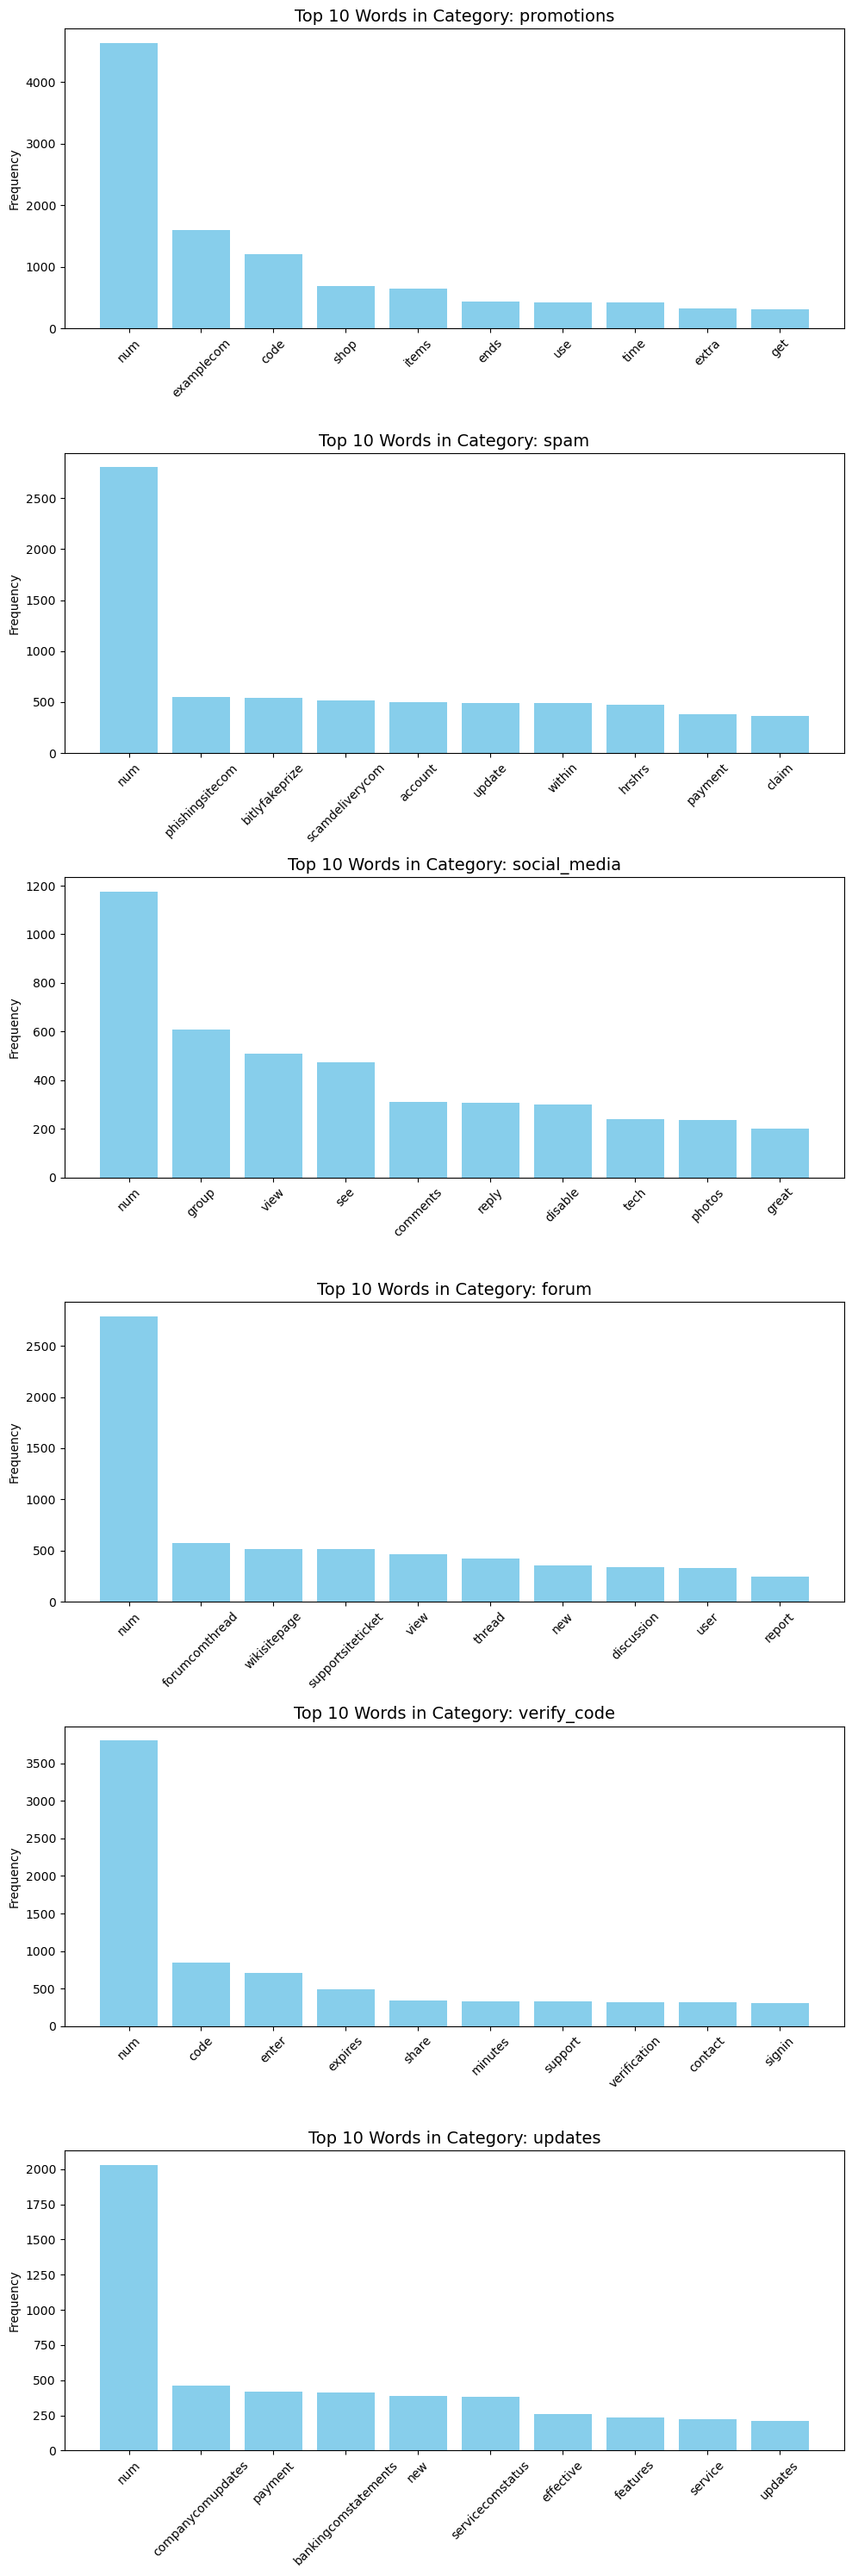

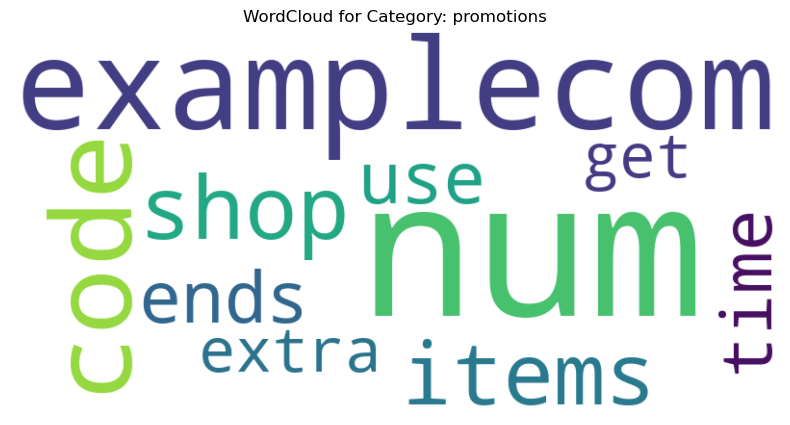

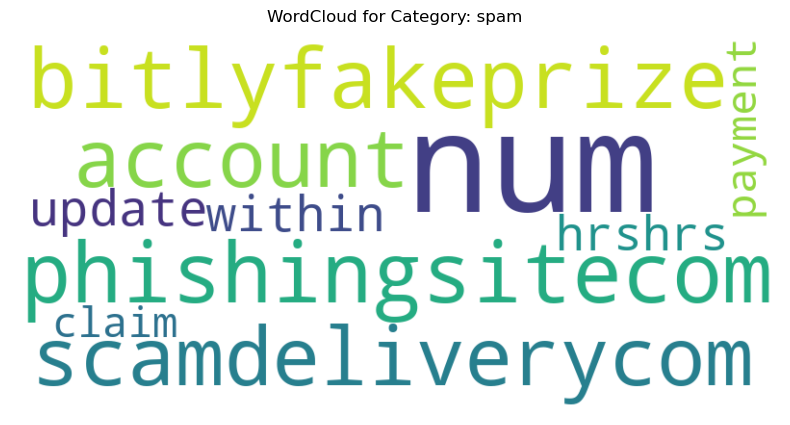

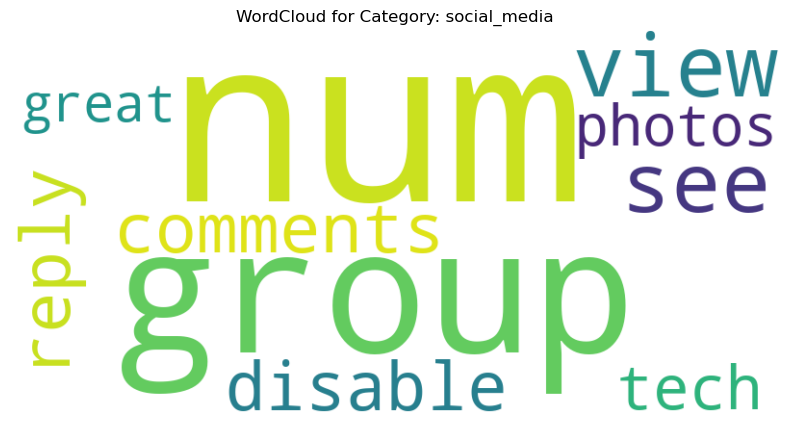

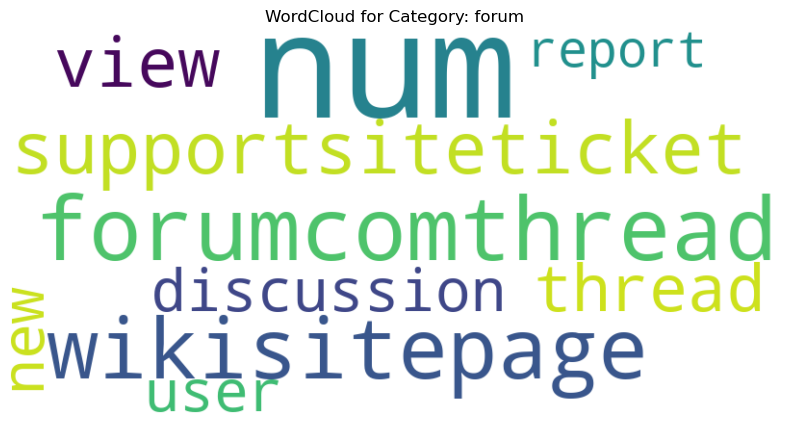

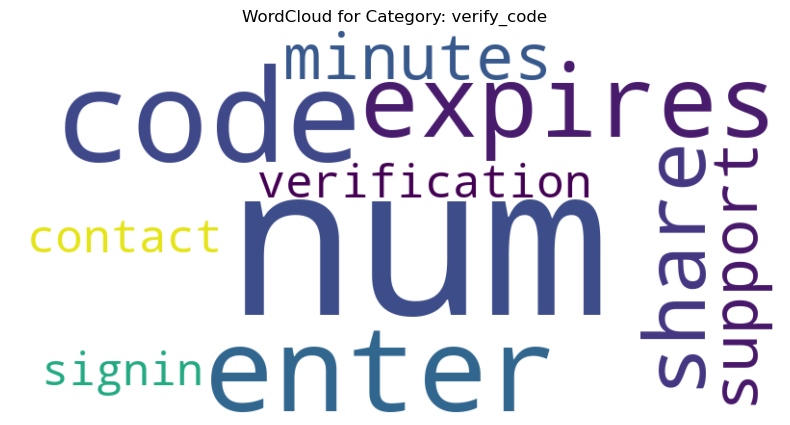

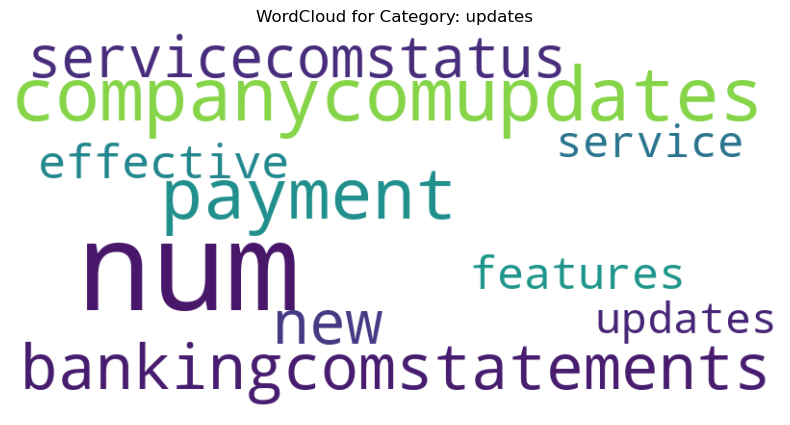

{'promotions': [('num', 4633),
  ('examplecom', 1594),
  ('code', 1213),
  ('shop', 692),
  ('items', 654),
  ('ends', 434),
  ('use', 431),
  ('time', 424),
  ('extra', 325),
  ('get', 311)],
 'spam': [('num', 2803),
  ('phishingsitecom', 553),
  ('bitlyfakeprize', 542),
  ('scamdeliverycom', 514),
  ('account', 502),
  ('update', 493),
  ('within', 487),
  ('hrshrs', 474),
  ('payment', 380),
  ('claim', 362)],
 'social_media': [('num', 1175),
  ('group', 609),
  ('view', 508),
  ('see', 473),
  ('comments', 309),
  ('reply', 306),
  ('disable', 301),
  ('tech', 238),
  ('photos', 236),
  ('great', 199)],
 'forum': [('num', 2790),
  ('forumcomthread', 571),
  ('wikisitepage', 518),
  ('supportsiteticket', 515),
  ('view', 464),
  ('thread', 419),
  ('new', 352),
  ('discussion', 338),
  ('user', 327),
  ('report', 243)],
 'verify_code': [('num', 3804),
  ('code', 845),
  ('enter', 704),
  ('expires', 490),
  ('share', 337),
  ('minutes', 327),
  ('support', 325),
  ('verification', 3

In [57]:
plot_top_words_per_category(train_df, text_col="body_normalized", label_col="category", top_n=10)

C:\Users\Nandita\AppData\Local\Temp\ipykernel_19600\2321396711.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words_, rotation=45)
C:\Users\Nandita\AppData\Local\Temp\ipykernel_19600\2321396711.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words_, rotation=45)
C:\Users\Nandita\AppData\Local\Temp\ipykernel_19600\2321396711.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words_, rotation=45)
C:\Users\Nandita\AppData\Local\Temp\ipykernel_19600\2321396711.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words_, rotation=45)
C:\Users\Nandita\AppData\Local\Temp\ipyk

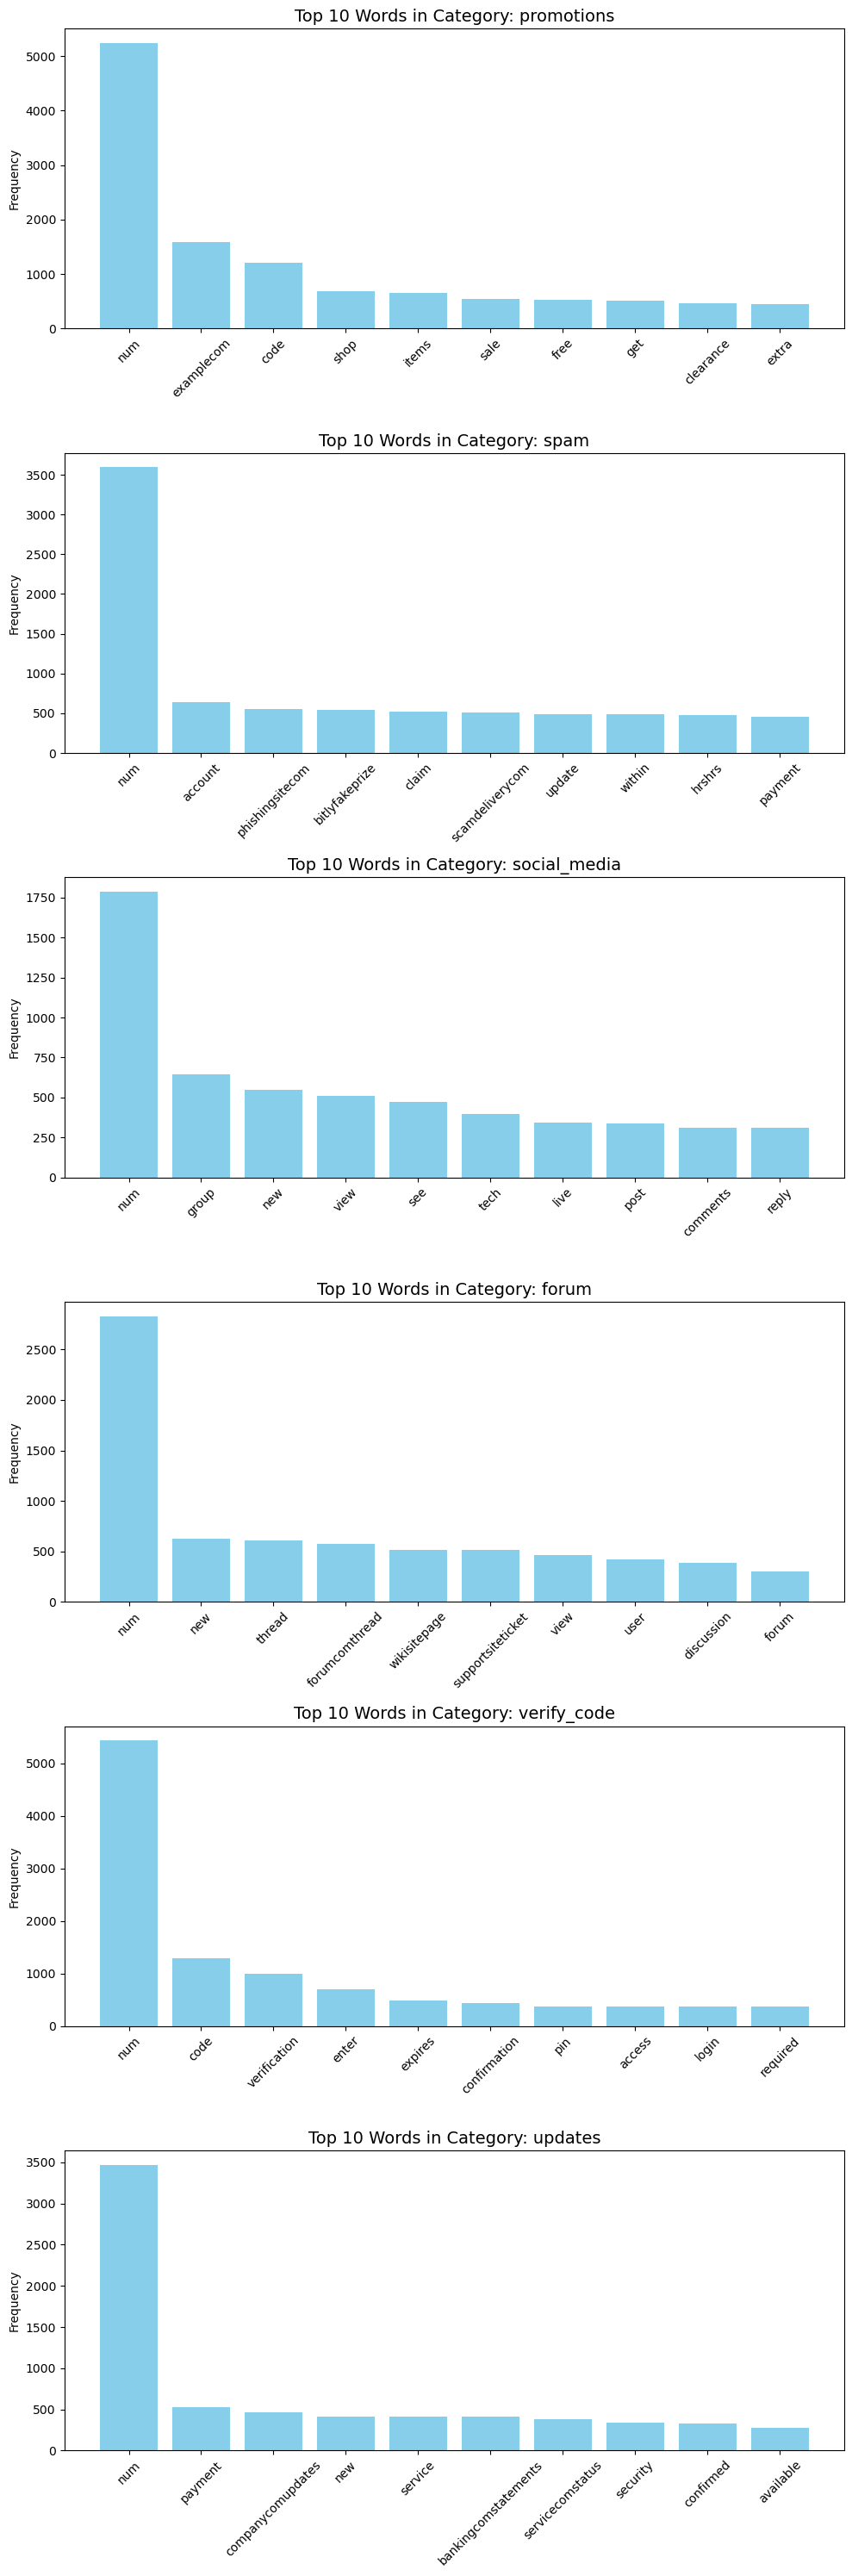

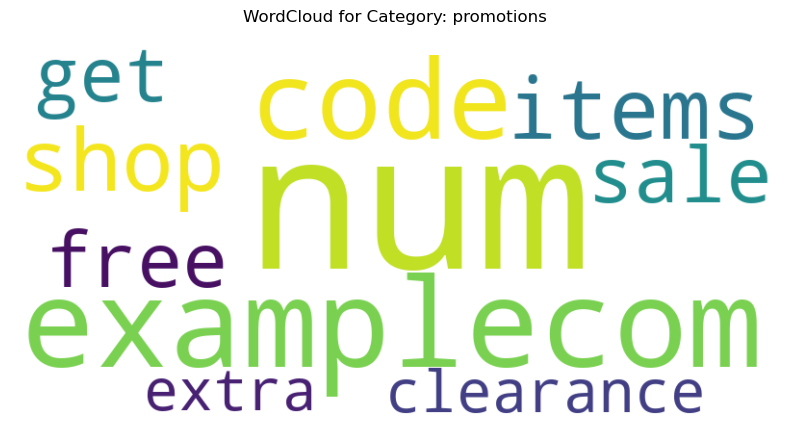

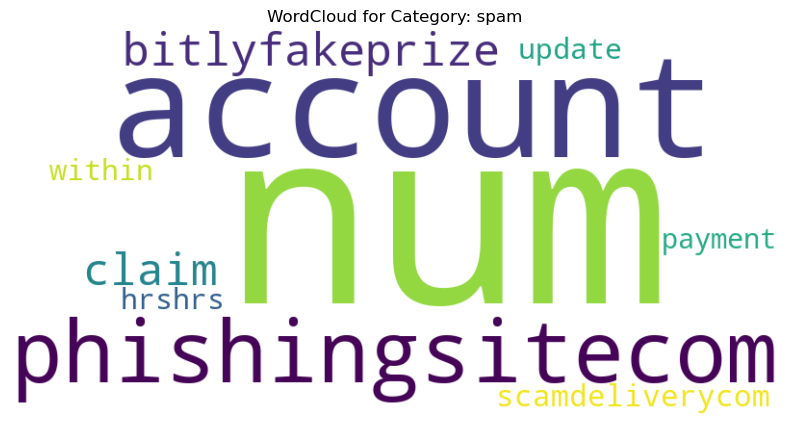

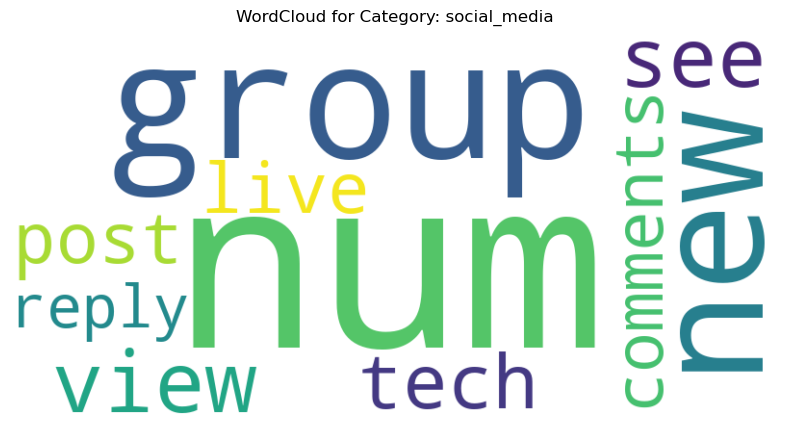

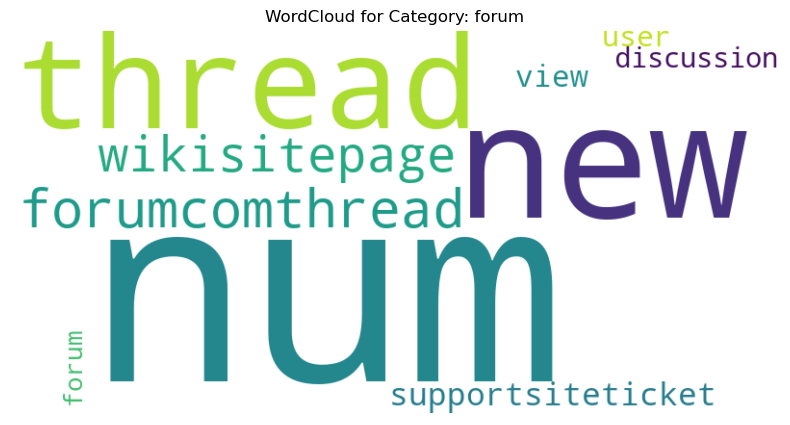

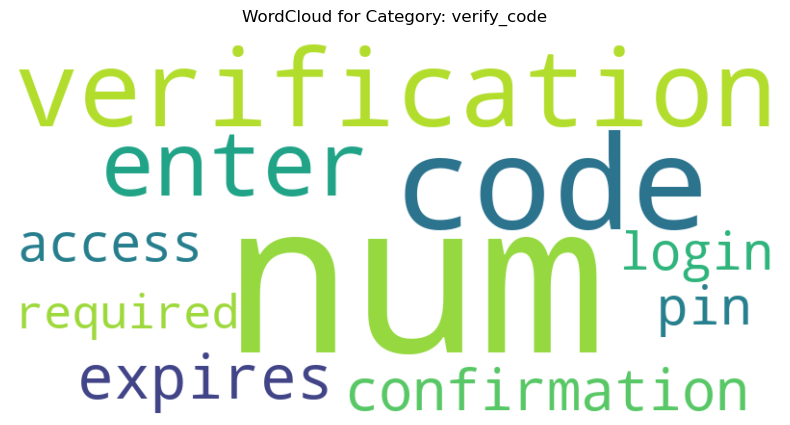

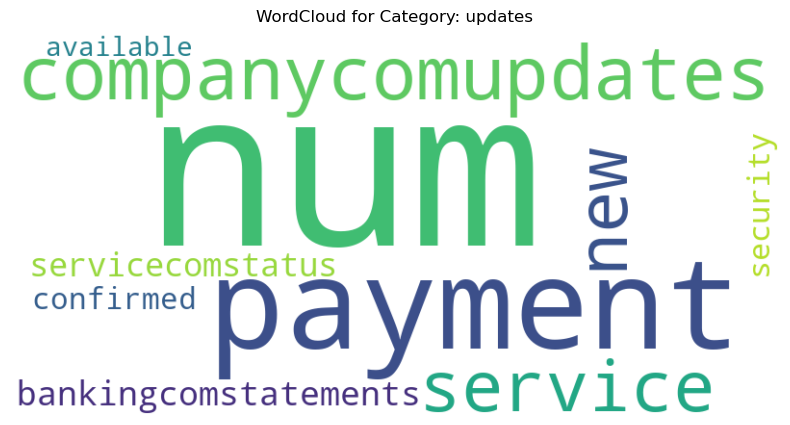

{'promotions': [('num', 5240),
  ('examplecom', 1594),
  ('code', 1213),
  ('shop', 692),
  ('items', 656),
  ('sale', 543),
  ('free', 528),
  ('get', 510),
  ('clearance', 458),
  ('extra', 445)],
 'spam': [('num', 3593),
  ('account', 636),
  ('phishingsitecom', 553),
  ('bitlyfakeprize', 542),
  ('claim', 517),
  ('scamdeliverycom', 514),
  ('update', 493),
  ('within', 487),
  ('hrshrs', 474),
  ('payment', 456)],
 'social_media': [('num', 1787),
  ('group', 645),
  ('new', 550),
  ('view', 508),
  ('see', 473),
  ('tech', 394),
  ('live', 341),
  ('post', 337),
  ('comments', 309),
  ('reply', 308)],
 'forum': [('num', 2831),
  ('new', 627),
  ('thread', 610),
  ('forumcomthread', 571),
  ('wikisitepage', 518),
  ('supportsiteticket', 515),
  ('view', 464),
  ('user', 424),
  ('discussion', 384),
  ('forum', 302)],
 'verify_code': [('num', 5436),
  ('code', 1290),
  ('verification', 995),
  ('enter', 704),
  ('expires', 490),
  ('confirmation', 432),
  ('pin', 380),
  ('access', 

In [59]:
plot_top_words_per_category(train_df, text_col="text_normalized", label_col="category", top_n=10)

C:\Users\Nandita\AppData\Local\Temp\ipykernel_19600\2321396711.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words_, rotation=45)
C:\Users\Nandita\AppData\Local\Temp\ipykernel_19600\2321396711.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words_, rotation=45)
C:\Users\Nandita\AppData\Local\Temp\ipykernel_19600\2321396711.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words_, rotation=45)
C:\Users\Nandita\AppData\Local\Temp\ipykernel_19600\2321396711.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words_, rotation=45)
C:\Users\Nandita\AppData\Local\Temp\ipyk

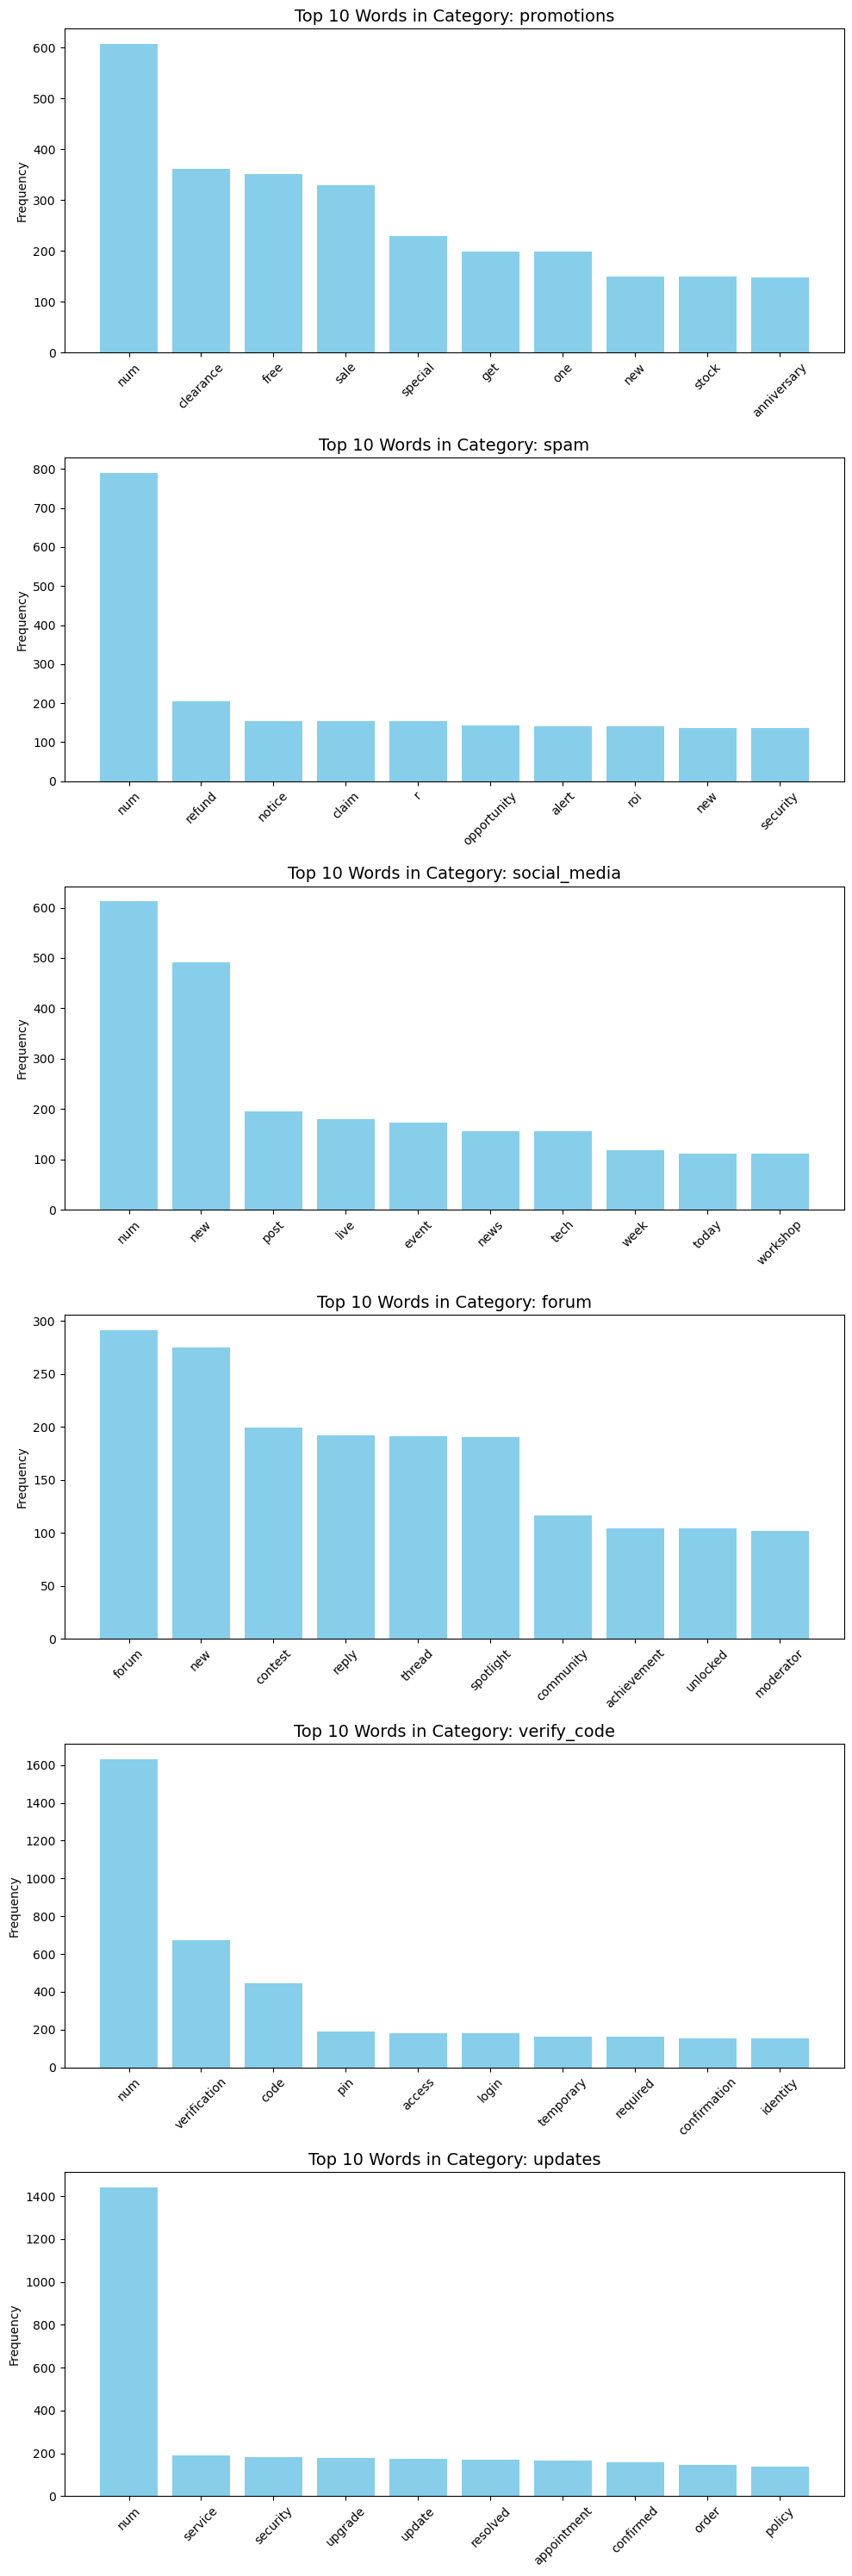

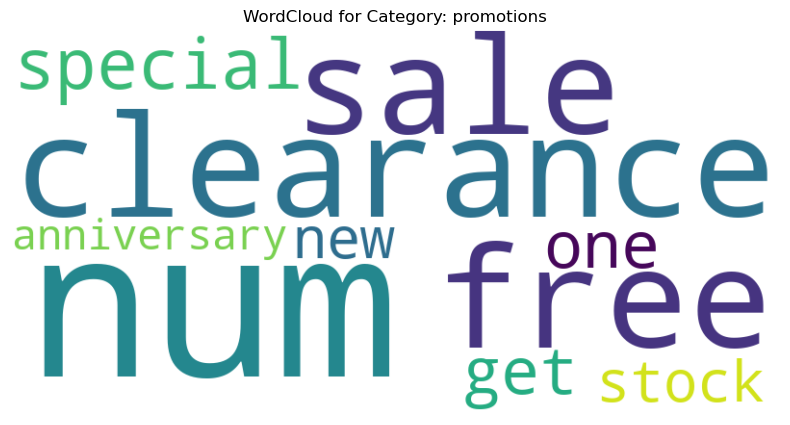

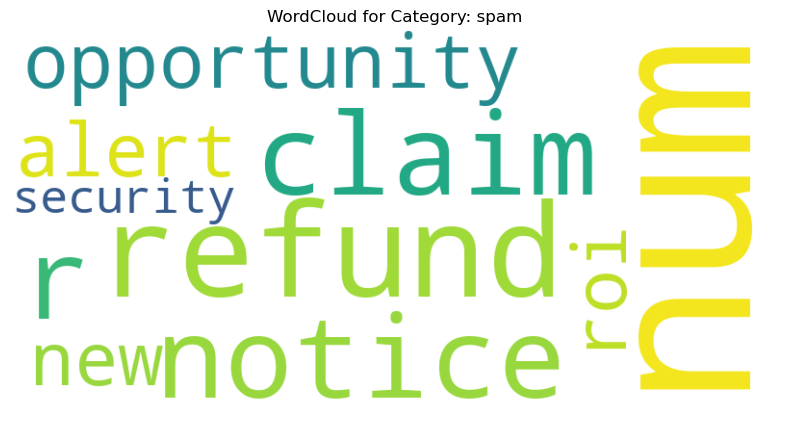

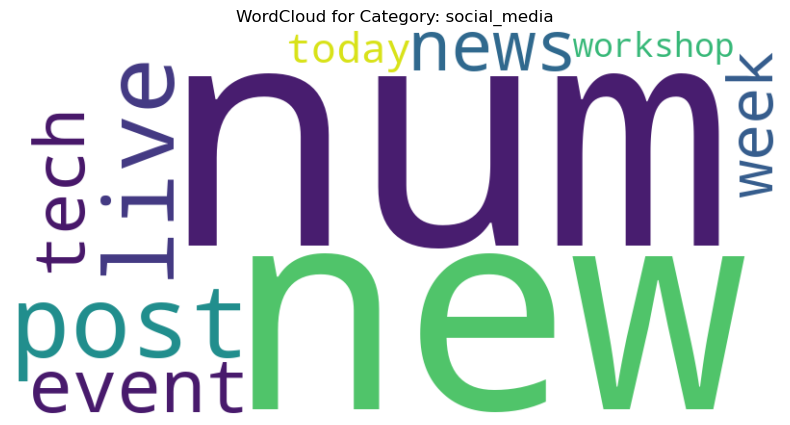

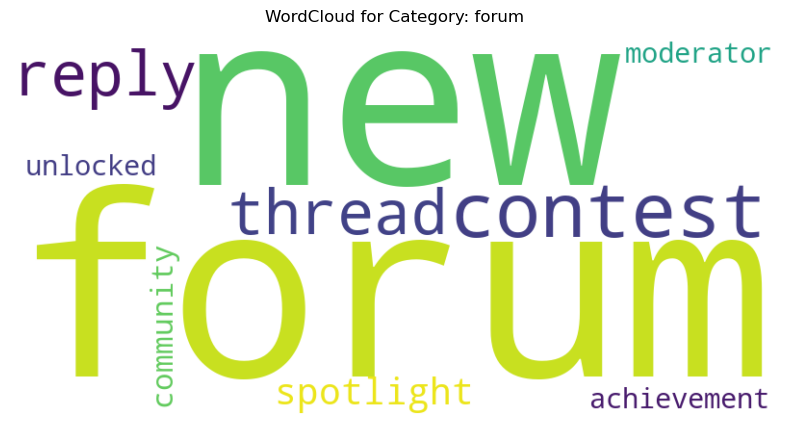

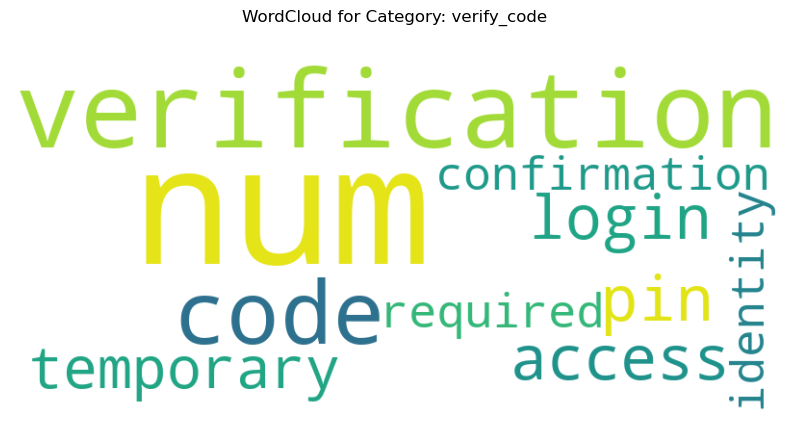

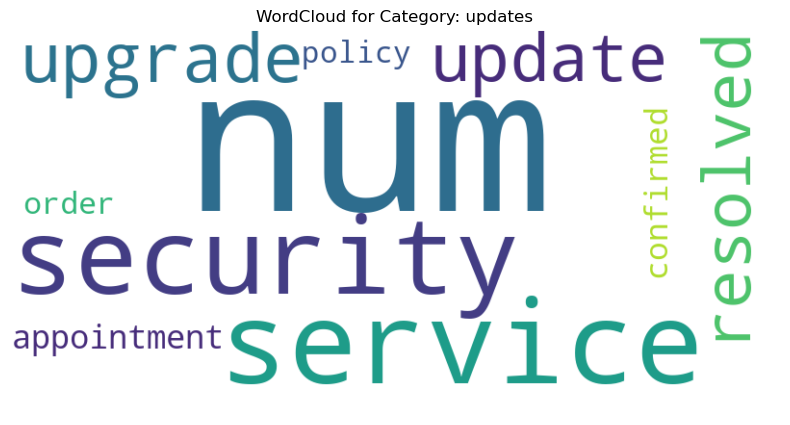

{'promotions': [('num', 607),
  ('clearance', 362),
  ('free', 351),
  ('sale', 330),
  ('special', 229),
  ('get', 199),
  ('one', 198),
  ('new', 150),
  ('stock', 150),
  ('anniversary', 147)],
 'spam': [('num', 790),
  ('refund', 205),
  ('notice', 155),
  ('claim', 155),
  ('r', 153),
  ('opportunity', 142),
  ('alert', 141),
  ('roi', 141),
  ('new', 137),
  ('security', 136)],
 'social_media': [('num', 612),
  ('new', 491),
  ('post', 196),
  ('live', 180),
  ('event', 173),
  ('news', 156),
  ('tech', 156),
  ('week', 119),
  ('today', 112),
  ('workshop', 111)],
 'forum': [('forum', 291),
  ('new', 275),
  ('contest', 199),
  ('reply', 192),
  ('thread', 191),
  ('spotlight', 190),
  ('community', 116),
  ('achievement', 104),
  ('unlocked', 104),
  ('moderator', 102)],
 'verify_code': [('num', 1632),
  ('verification', 674),
  ('code', 445),
  ('pin', 190),
  ('access', 183),
  ('login', 179),
  ('temporary', 163),
  ('required', 162),
  ('confirmation', 155),
  ('identity', 

In [65]:
plot_top_words_per_category(train_df, text_col="subject_normalized", label_col="category", top_n=10)

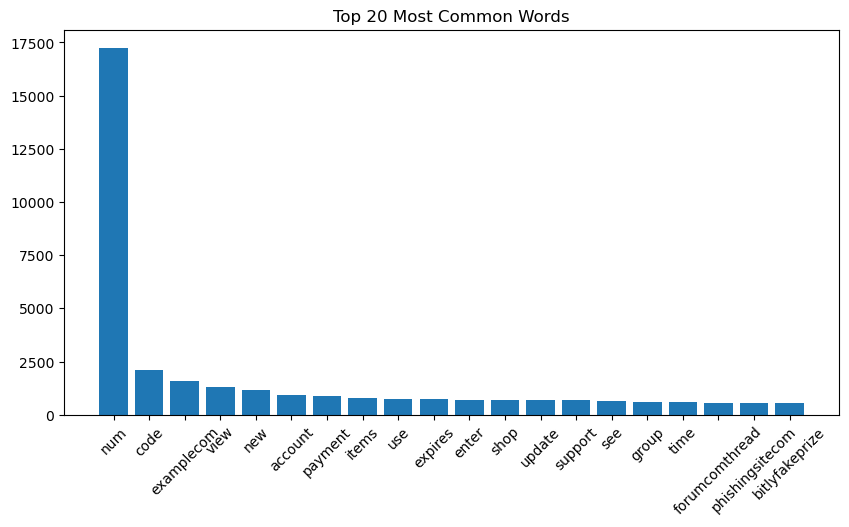

In [60]:
common_words = word_freq.most_common(20)
words, counts = zip(*common_words)

plt.figure(figsize=(10,5))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title("Top 20 Most Common Words")
plt.show()

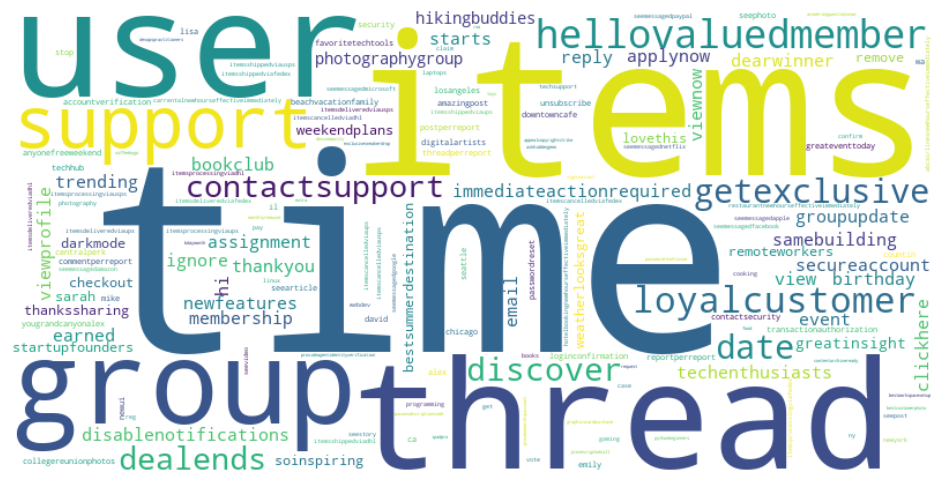

In [60]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

C:\Users\Nandita\AppData\Local\Temp\ipykernel_14464\2321396711.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words_, rotation=45)
C:\Users\Nandita\AppData\Local\Temp\ipykernel_14464\2321396711.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words_, rotation=45)
C:\Users\Nandita\AppData\Local\Temp\ipykernel_14464\2321396711.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words_, rotation=45)
C:\Users\Nandita\AppData\Local\Temp\ipykernel_14464\2321396711.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words_, rotation=45)
C:\Users\Nandita\AppData\Local\Temp\ipyk

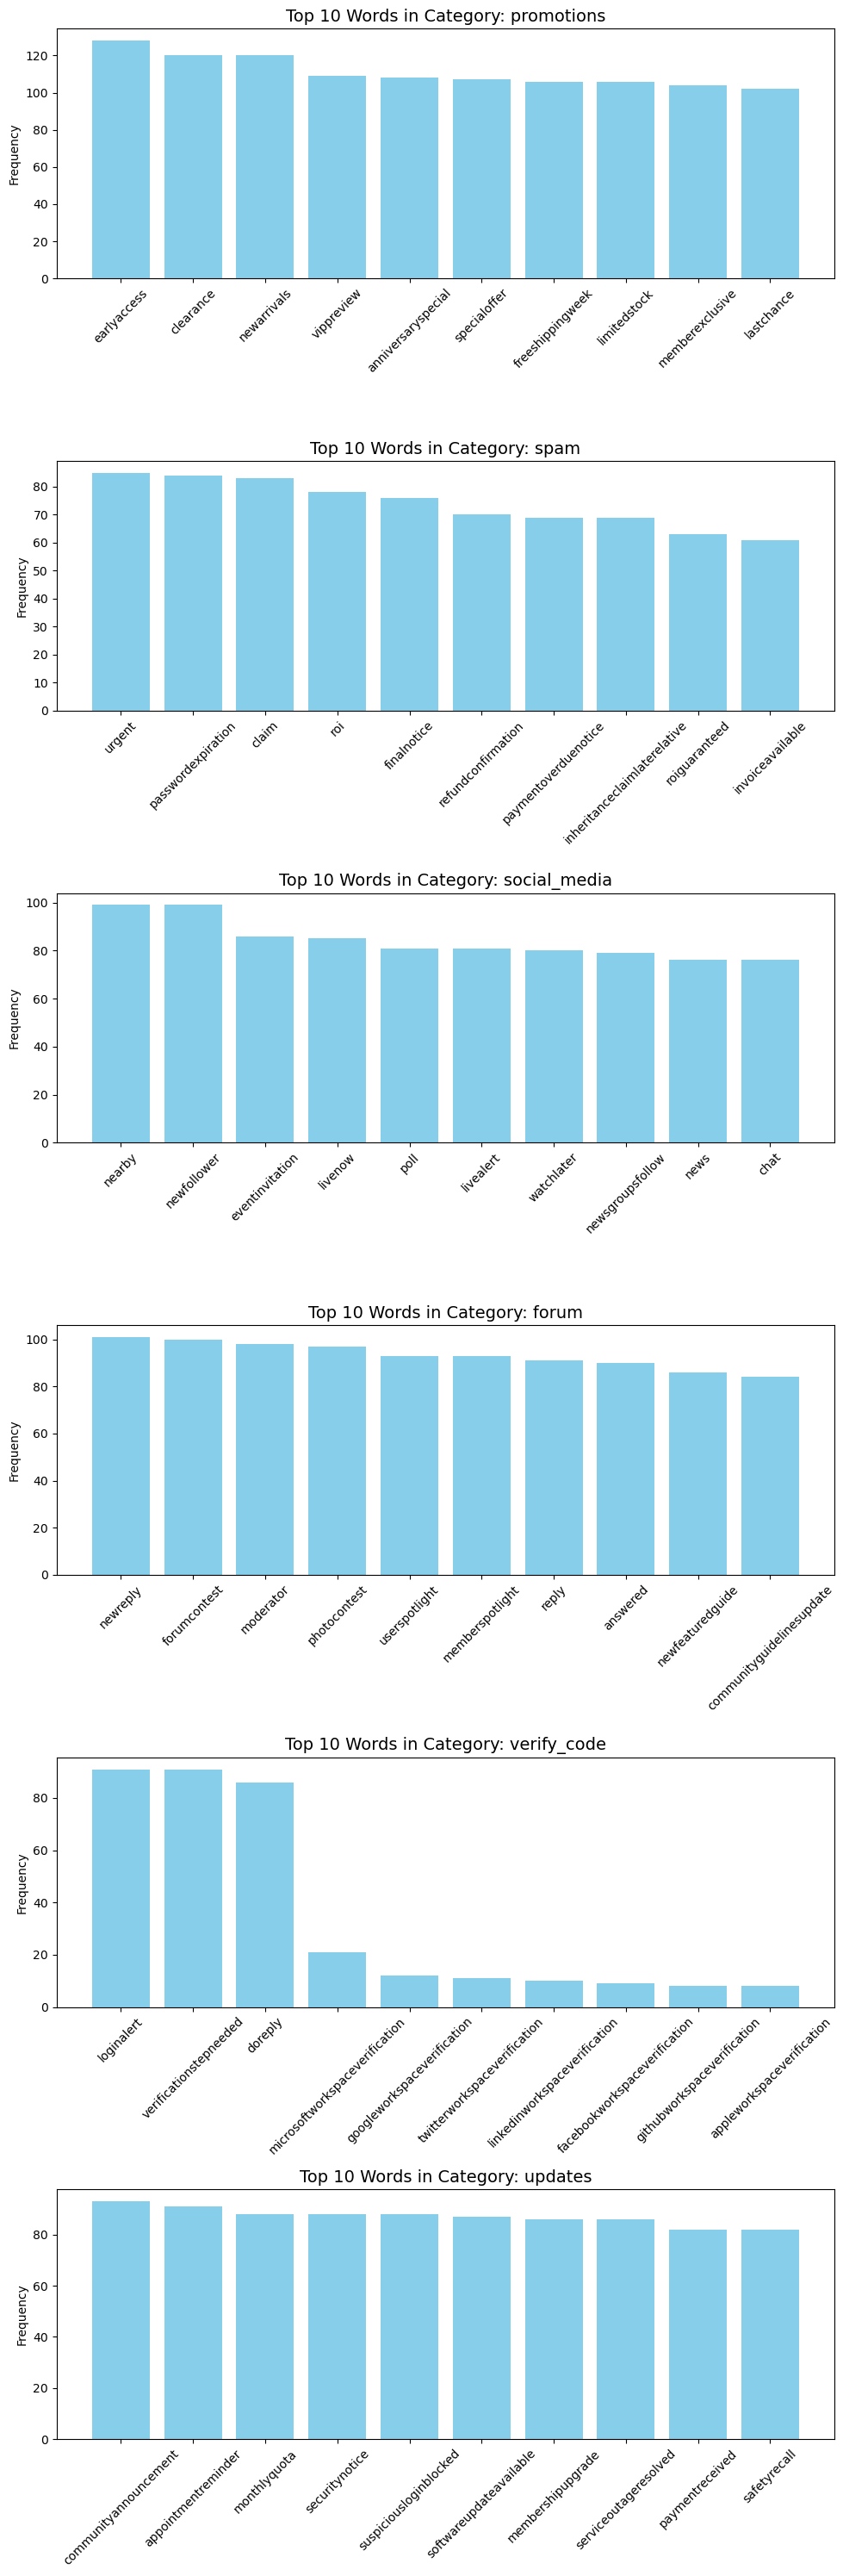

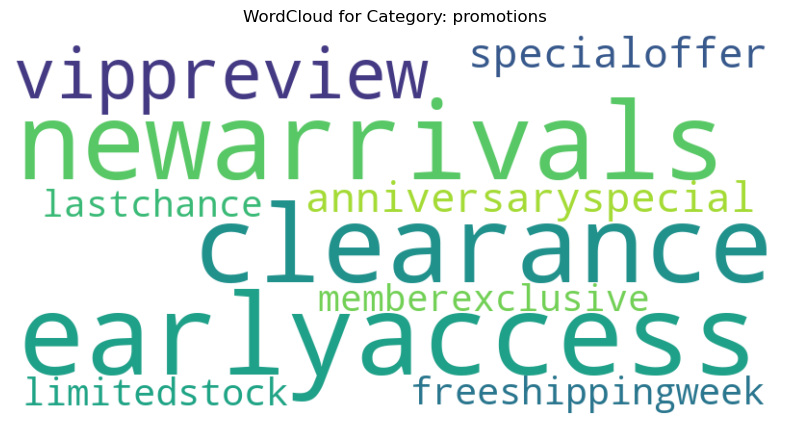

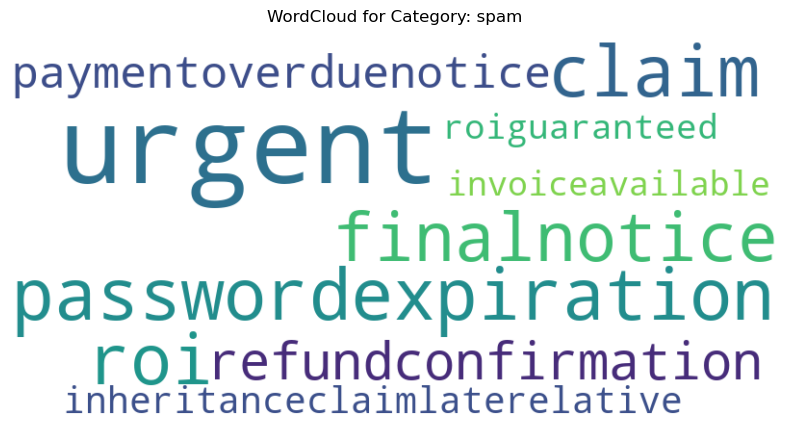

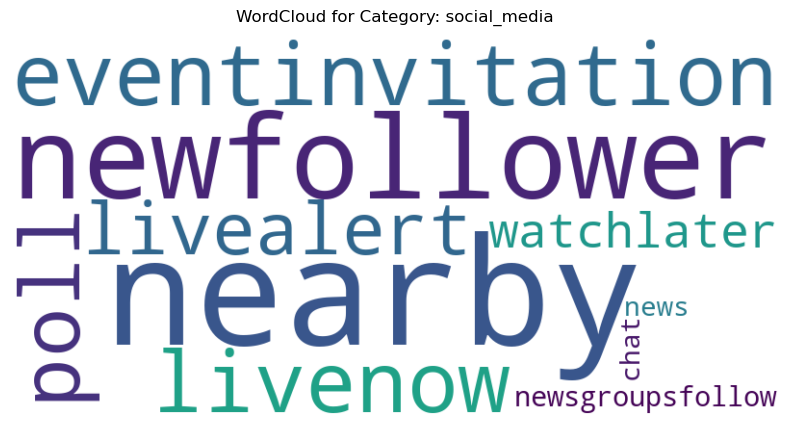

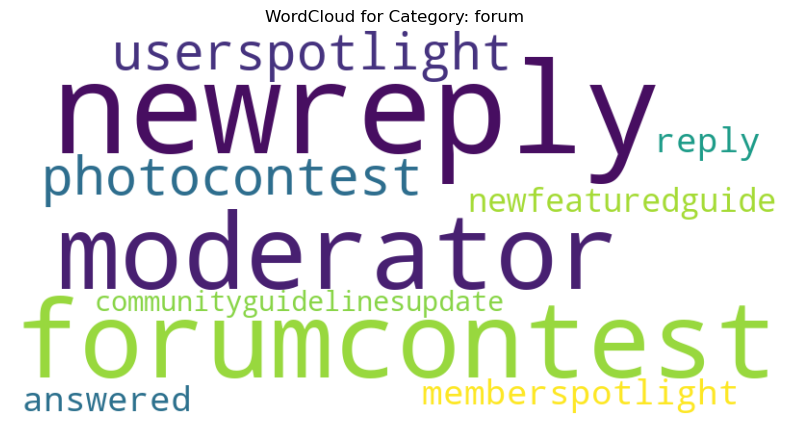

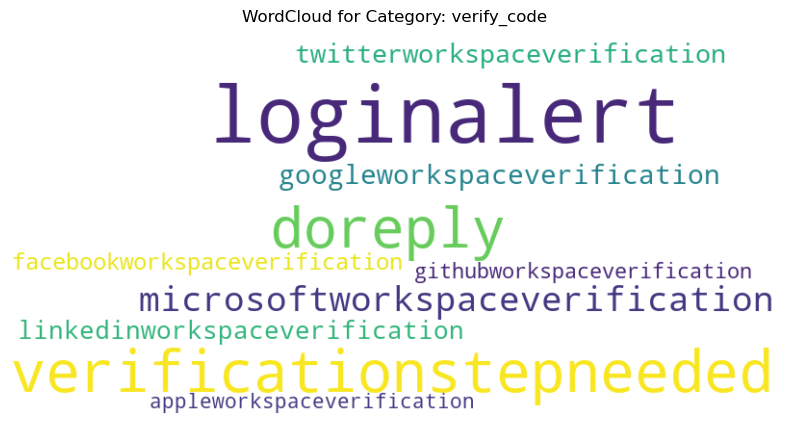

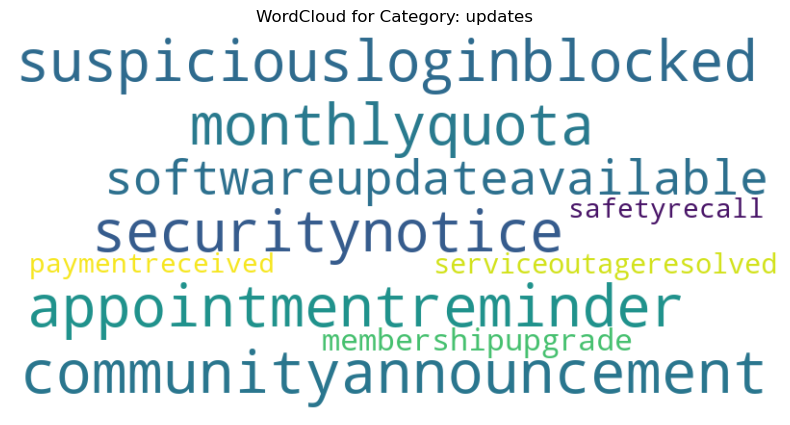

{'promotions': [('earlyaccess', 128),
  ('clearance', 120),
  ('newarrivals', 120),
  ('vippreview', 109),
  ('anniversaryspecial', 108),
  ('specialoffer', 107),
  ('freeshippingweek', 106),
  ('limitedstock', 106),
  ('memberexclusive', 104),
  ('lastchance', 102)],
 'spam': [('urgent', 85),
  ('passwordexpiration', 84),
  ('claim', 83),
  ('roi', 78),
  ('finalnotice', 76),
  ('refundconfirmation', 70),
  ('paymentoverduenotice', 69),
  ('inheritanceclaimlaterelative', 69),
  ('roiguaranteed', 63),
  ('invoiceavailable', 61)],
 'social_media': [('nearby', 99),
  ('newfollower', 99),
  ('eventinvitation', 86),
  ('livenow', 85),
  ('poll', 81),
  ('livealert', 81),
  ('watchlater', 80),
  ('newsgroupsfollow', 79),
  ('news', 76),
  ('chat', 76)],
 'forum': [('newreply', 101),
  ('forumcontest', 100),
  ('moderator', 98),
  ('photocontest', 97),
  ('userspotlight', 93),
  ('memberspotlight', 93),
  ('reply', 91),
  ('answered', 90),
  ('newfeaturedguide', 86),
  ('communityguidelinesu

In [70]:
plot_top_words_per_category(train, text_col="subject_normalized", label_col="category", top_n=10)

In [66]:
def get_bigrams(df,text_col):
    cv = CountVectorizer(ngram_range=(2,2))
    bigram = cv.fit_transform(df[text_col])
    count_values = bigram.toarray().sum(axis=0)
    ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
    ngram_freq.columns = ["frequency", "ngram"]
    return ngram_freq

In [74]:
bigram_freq = get_bigrams(train_df,text_col='body')

In [75]:
bigram_freq.head()

frequency         ngram
0       1595   example com
1       1173    social com
2        871  platform com
3        680     forum com
4        571    thread 123

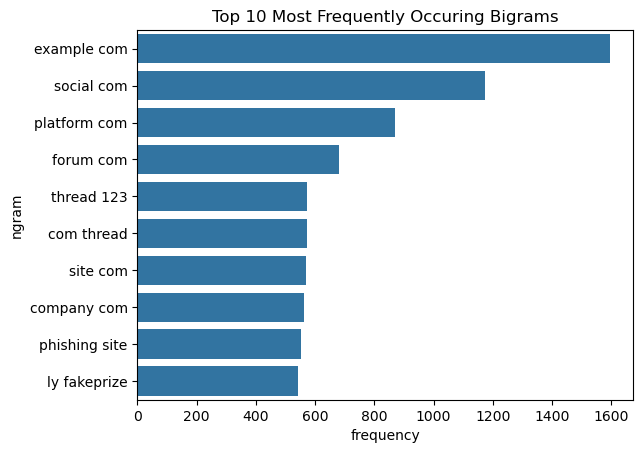

In [76]:
sns.barplot(x=bigram_freq['frequency'][:10], y=bigram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

In [77]:
bigram_freq_text = get_bigrams(train_df,text_col='text')

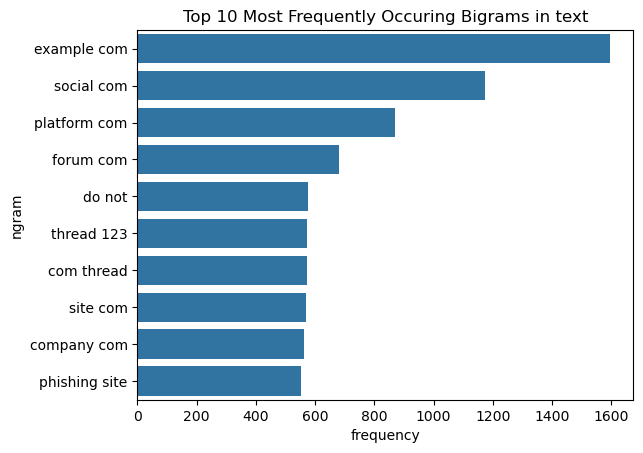

In [78]:
sns.barplot(x=bigram_freq_text['frequency'][:10], y=bigram_freq_text['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams in text')
plt.show()

In [87]:
bigram_freq_subject = get_bigrams(train_df,text_col='subject')

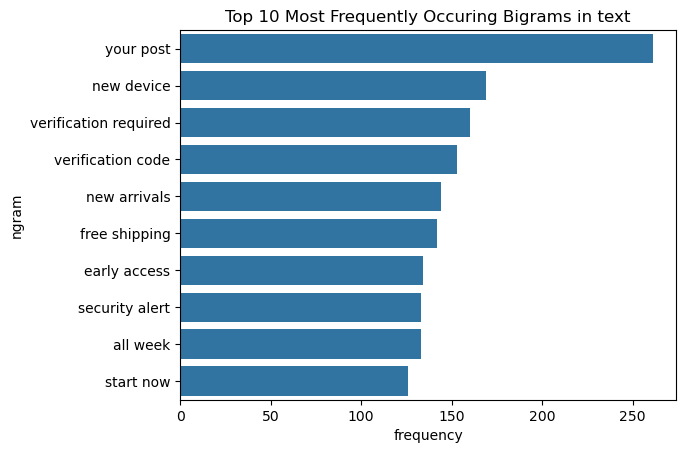

In [88]:
sns.barplot(x=bigram_freq_subject['frequency'][:10], y=bigram_freq_subject['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams in text')
plt.show()

In [72]:
def get_trigrams(df,text_col):
    cv = CountVectorizer(ngram_range=(3,3))
    bigram = cv.fit_transform(df[text_col])
    count_values = bigram.toarray().sum(axis=0)
    ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
    ngram_freq.columns = ["frequency", "ngram"]
    return ngram_freq

In [81]:
trigram_freq_body = get_trigrams(train_df,text_col='body')

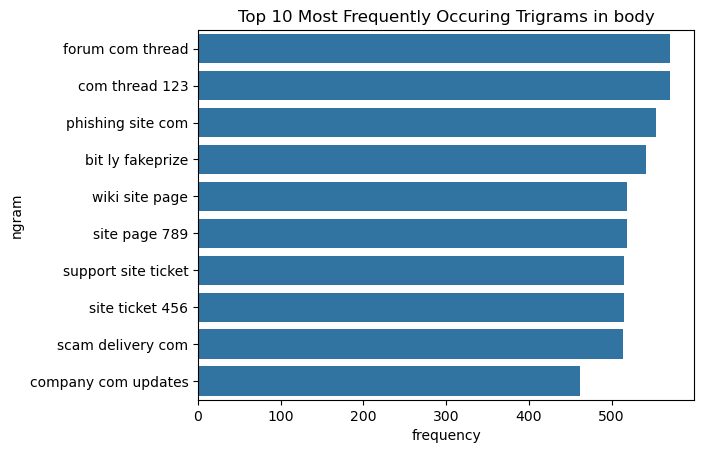

In [84]:
sns.barplot(x=trigram_freq_body['frequency'][:10], y=trigram_freq_body['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Trigrams in body')
plt.show()

In [89]:
trigram_freq_subject = get_trigrams(train_df,text_col='subject')

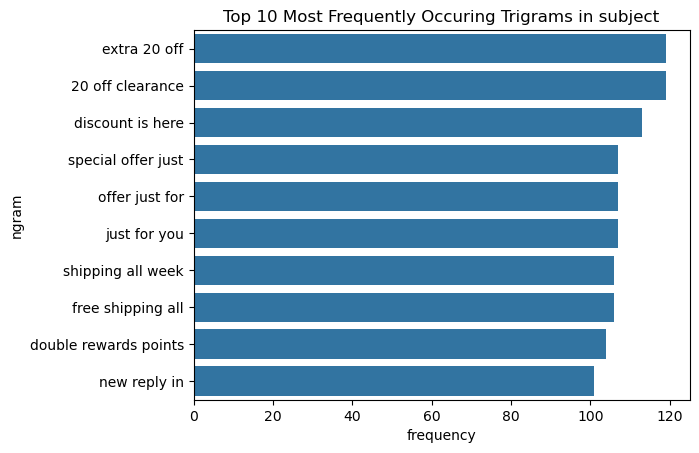

In [90]:
sns.barplot(x=trigram_freq_subject['frequency'][:10], y=trigram_freq_subject['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Trigrams in subject')
plt.show()